In [1]:
### IMPORTS ###
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter
import glob
import pickle
from datetime import datetime
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [ ]:
# ### FUNCTION TO COMPUTE CHANNEL TUNING ###
# def compute_channel_tuning_with_history(data, n_lags=5, alpha=1.0):
#     """
#     Compute channel tuning using time history with Ridge Regression
    
#     Parameters:
#     - data: dictionary containing 'finger_kinematics' and 'sbp'
#     - n_lags: number of time lags to include
#     - alpha: regularization strength for Ridge Regression
#     """
#     # Extract data
#     if isinstance(data, tuple):
#         if data[0] is None and isinstance(data[1], dict):
#             data = data[1]
#         elif isinstance(data[0], dict):
#             data = data[0]
#         else:
#             print(f"Unexpected data structure: {type(data)}")
#             return None

#     finger_kinematics = data['finger_kinematics']
#     sbp = data['sbp']
    
#     # Initialize scaler
#     scaler = StandardScaler()
#     channel_tuning = {}
    
#     for i in range(sbp.shape[1]):  # Iterate over channels
#         channel_data = sbp[:, i]
        
#         # Skip if data is constant
#         if np.all(channel_data == channel_data[0]) or np.all(finger_kinematics[:, 0] == finger_kinematics[0, 0]) or np.all(finger_kinematics[:, 1] == finger_kinematics[0, 1]):
#             channel_tuning[f'sbp_channel_{i}'] = {
#                 'magnitude': 0,
#                 'angle': 0,
#                 'corr_index': 0,
#                 'corr_mrp': 0,
#                 'prediction_correlation': 0
#             }
#             continue
            
#         # Create lagged features
#         X = np.zeros((len(channel_data) - n_lags, n_lags))
#         for lag in range(n_lags):
#             X[:, lag] = channel_data[lag:len(channel_data)-n_lags+lag]
        
#         # Target is the next time point
#         y = channel_data[n_lags:]
        
#         # Scale the features
#         X_scaled = scaler.fit_transform(X)
        
#         # Fit Ridge regression
#         model = Ridge(alpha=alpha)
#         model.fit(X_scaled, y)
        
#         # Make predictions
#         predictions = model.predict(X_scaled)
        
#         # Calculate prediction correlation
#         pred_corr = np.corrcoef(predictions, y)[0, 1]
        
#         # Traditional correlations
#         corr_index = stats.pearsonr(channel_data, finger_kinematics[:, 0])[0]
#         corr_mrp = stats.pearsonr(channel_data, finger_kinematics[:, 1])[0]
        
#         # Calculate magnitude and angle
#         magnitude = np.sqrt(corr_index**2 + corr_mrp**2)
#         angle = np.degrees(np.arctan2(corr_mrp, corr_index))
        
#         channel_tuning[f'sbp_channel_{i}'] = {
#             'magnitude': magnitude,
#             'angle': angle,
#             'corr_index': corr_index,
#             'corr_mrp': corr_mrp,
#             'prediction_correlation': pred_corr,
#             'predicted_values': predictions,
#             'actual_values': y,
#             'model_coefficients': model.coef_
#         }
    
#     return channel_tuning


In [2]:
def compute_behavior_prediction_tuning(data, n_lags=5, alpha=1.0):
    """
    Compute tuning by predicting finger kinematics from neural data using a sliding window
    of previous timepoints to predict one step ahead
    
    Parameters:
    - data: dictionary containing 'finger_kinematics' and 'sbp'
    - n_lags: number of previous time points to use for prediction
    - alpha: regularization strength for Ridge Regression
    """
    # Extract data
    if isinstance(data, tuple):
        if data[0] is None and isinstance(data[1], dict):
            data = data[1]
        elif isinstance(data[0], dict):
            data = data[0]
        else:
            print(f"Unexpected data structure: {type(data)}")
            return None

    finger_kinematics = data['finger_kinematics']
    sbp = data['sbp']
    
    # Initialize scaler and storage
    scaler = StandardScaler()
    channel_tuning = {}
    
    # Create lagged features matrix for each channel
    for i in range(sbp.shape[1]):  # Iterate over channels
        channel_data = sbp[:, i]
        
        # Skip if data is constant
        if np.all(channel_data == channel_data[0]):
            channel_tuning[f'sbp_channel_{i}'] = {
                'magnitude': 0,
                'angle': 0,
                'prediction_correlation_dim1': 0,
                'prediction_correlation_dim2': 0
            }
            continue
            
        # Create lagged features using sliding window
        X_lagged = np.array([channel_data[j:j+n_lags+1] for j in range(len(channel_data)-n_lags)])
        X_scaled = scaler.fit_transform(X_lagged)

        split_index = int(0.8 * len(X_scaled))  # 80% train, 20% test
        X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
        
        # Target is the next time point after the n_lags window
        y_dim1 = finger_kinematics[n_lags:, 0]
        y_dim2 = finger_kinematics[n_lags:, 1]

        y_train_dim1, y_test_dim1 = y_dim1[:split_index], y_dim1[split_index:]
        y_train_dim2, y_test_dim2 = y_dim2[:split_index], y_dim2[split_index:]
        
        # Fit models for each dimension
        model_dim1 = Ridge(alpha=alpha)
        model_dim2 = Ridge(alpha=alpha)
        
        # model_dim1.fit(X_scaled, y_dim1)
        # model_dim2.fit(X_scaled, y_dim2)

        model_dim1.fit(X_train, y_train_dim1)
        model_dim2.fit(X_train, y_train_dim2)
        
        # Make predictions
        # pred_dim1 = model_dim1.predict(X_scaled)
        # pred_dim2 = model_dim2.predict(X_scaled)

        pred_dim1 = model_dim1.predict(X_test)
        pred_dim2 = model_dim2.predict(X_test)
        
        # Calculate prediction correlations
        # corr_dim1 = np.corrcoef(pred_dim1, y_dim1)[0, 1]
        # corr_dim2 = np.corrcoef(pred_dim2, y_dim2)[0, 1]
        corr_dim1 = np.corrcoef(pred_dim1, y_test_dim1)[0, 1]
        corr_dim2 = np.corrcoef(pred_dim2, y_test_dim2)[0, 1]
        
        
        # Calculate magnitude and angle
        magnitude = np.sqrt(corr_dim1**2 + corr_dim2**2)
        angle = np.degrees(np.arctan2(corr_dim2, corr_dim1))
        # magnitude = np.sqrt(np.sum(model_dim1.coef_**2) + np.sum(model_dim2.coef_**2))
        # angle = np.degrees(np.arctan2(np.sum(model_dim2.coef_), np.sum(model_dim1.coef_)))
        
        channel_tuning[f'sbp_channel_{i}'] = {
            'magnitude': magnitude,
            'angle': angle,
            'prediction_correlation_dim1': corr_dim1,
            'prediction_correlation_dim2': corr_dim2,
            'mean_sbp': np.mean(channel_data)
        }

    
    return channel_tuning



In [ ]:
### LOAD AND PREPROCESS DATA ###

# Approximate total number of datasets
total_datasets = 415

# Create a progress bar
pbar = tqdm(total=total_datasets, desc="Processing datasets")

# Path to the folder containing pkl files
data_folder = './preprocessing_092024'

# Get list of pkl files
pkl_files = sorted(glob.glob(os.path.join(data_folder, '*.pkl')))

# Dictionary to store results
results = {}

# Process each pkl file
# counter = 0
for file in pkl_files:
    # Extract date from filename (assuming format like 'YYYY-MM-DD_data.pkl')
    date = pd.to_datetime(os.path.basename(file).split('_')[0])

    # Load data
    with open(file, 'rb') as f:
        data = pickle.load(f)
        
    # Compute channel tuning
    try:
        channel_tuning = compute_behavior_prediction_tuning(data)
        if channel_tuning is not None:
            results[date] = channel_tuning
    except Exception as e:
        print(f"Error processing file {file}: {str(e)}")
        continue

    # Update the progress bar
    pbar.update(1)
    
    # Store results
    results[date] = channel_tuning

    # counter += 1
    # if counter == 25:
    #     break

# Close the progress bar
pbar.close()

In [3]:
### LOAD AND PREPROCESS DATA ###

# Approximate total number of datasets
total_datasets = 100

# Create a progress bar
pbar = tqdm(total=total_datasets, desc="Processing datasets")

# Path to the folder containing pkl files
data_folder = './preprocessing_092024'

# Get list of pkl files
pkl_files = sorted(glob.glob(os.path.join(data_folder, '*.pkl')))

# Dictionary to store results
mean_included_results = {}

# Process each pkl file
counter = 0
for file in pkl_files:
    # Extract date from filename (assuming format like 'YYYY-MM-DD_data.pkl')
    date = pd.to_datetime(os.path.basename(file).split('_')[0])

    # Load data
    with open(file, 'rb') as f:
        data = pickle.load(f)
        
    # Compute channel tuning
    try:
        channel_tuning = compute_behavior_prediction_tuning(data)
        if channel_tuning is not None:
            mean_included_results[date] = channel_tuning
    except Exception as e:
        print(f"Error processing file {file}: {str(e)}")
        continue

    # Update the progress bar
    pbar.update(1)
    
    # Store results
    mean_included_results[date] = channel_tuning

    counter += 1
    if counter == 100:
        break

# Close the progress bar
pbar.close()

Processing datasets:   0%|          | 0/100 [00:00<?, ?it/s]

Processing datasets: 100%|██████████| 100/100 [11:03<00:00,  6.63s/it]


In [4]:
### PREPARE DATA FOR VISUALIZATION ###
def prepare_tuning_data(results):
    # Create lists to store data
    dates = []
    channels = []
    magnitudes = []
    angles = []
    sbps = []

    for date, channel_data in results.items():
        for channel, metrics in channel_data.items():
            if 'mean_sbp' in metrics:
                dates.append(date)
                channels.append(channel)
                magnitudes.append(metrics['magnitude'])
                angles.append(metrics['angle'])
                sbps.append(metrics['mean_sbp'])
            else:
                dates.append(date)
                channels.append(channel)
                magnitudes.append(metrics['magnitude'])
                angles.append(metrics['angle'])
                sbps.append(0)

    
    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'channel': channels,
        'magnitude': magnitudes,
        'angle': angles,
        'mean_sbps': sbps
    })
    
    return df.pivot(index='date', columns='channel')

# Convert results to organized DataFrame
#df_tuning = prepare_tuning_data(results)
df_tuning_mean_included = prepare_tuning_data(mean_included_results)

/var/folders/vs/x5my52wn5jv64c7gz3gxk3th0000gn/T/ipykernel_41401/2348023894.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  angles = df_tuning['angle'].loc[time_point][80] #.values  # First 5 channels
/var/folders/vs/x5my52wn5jv64c7gz3gxk3th0000gn/T/ipykernel_41401/2348023894.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  magnitudes = df_tuning['magnitude'].loc[time_point][80] #.values


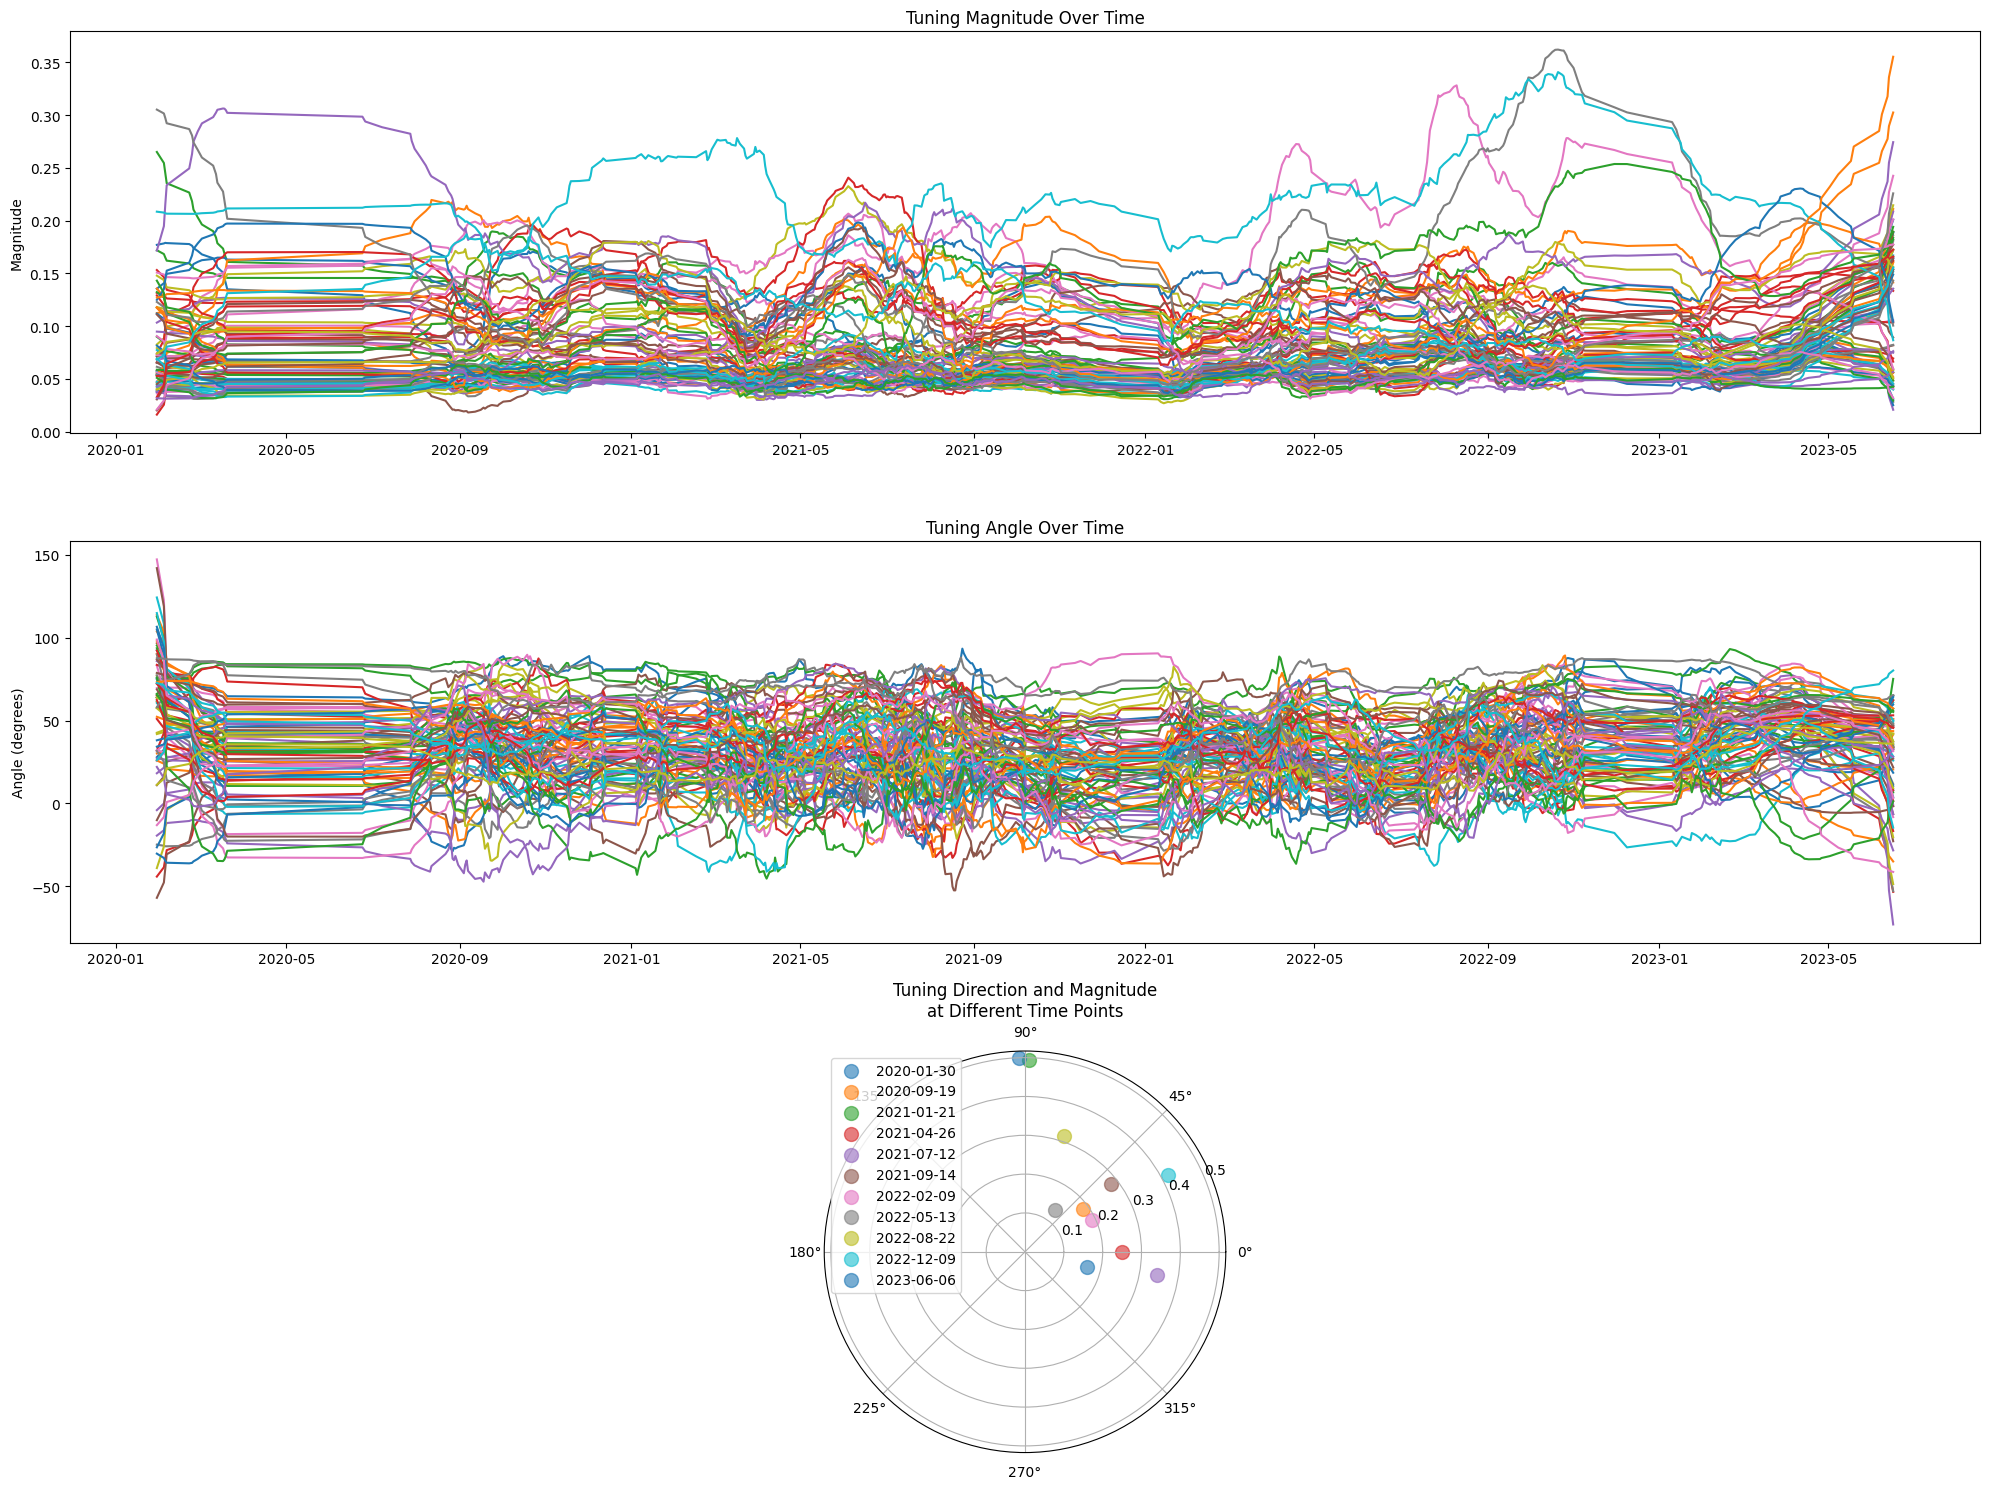

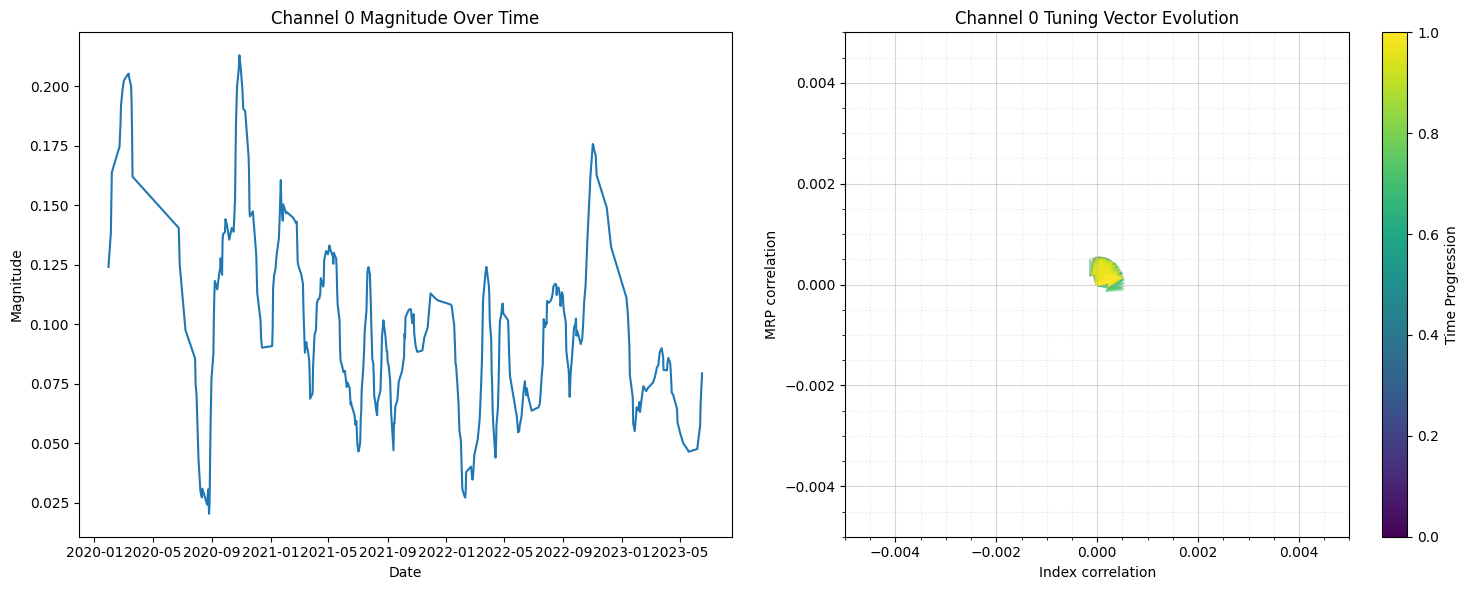

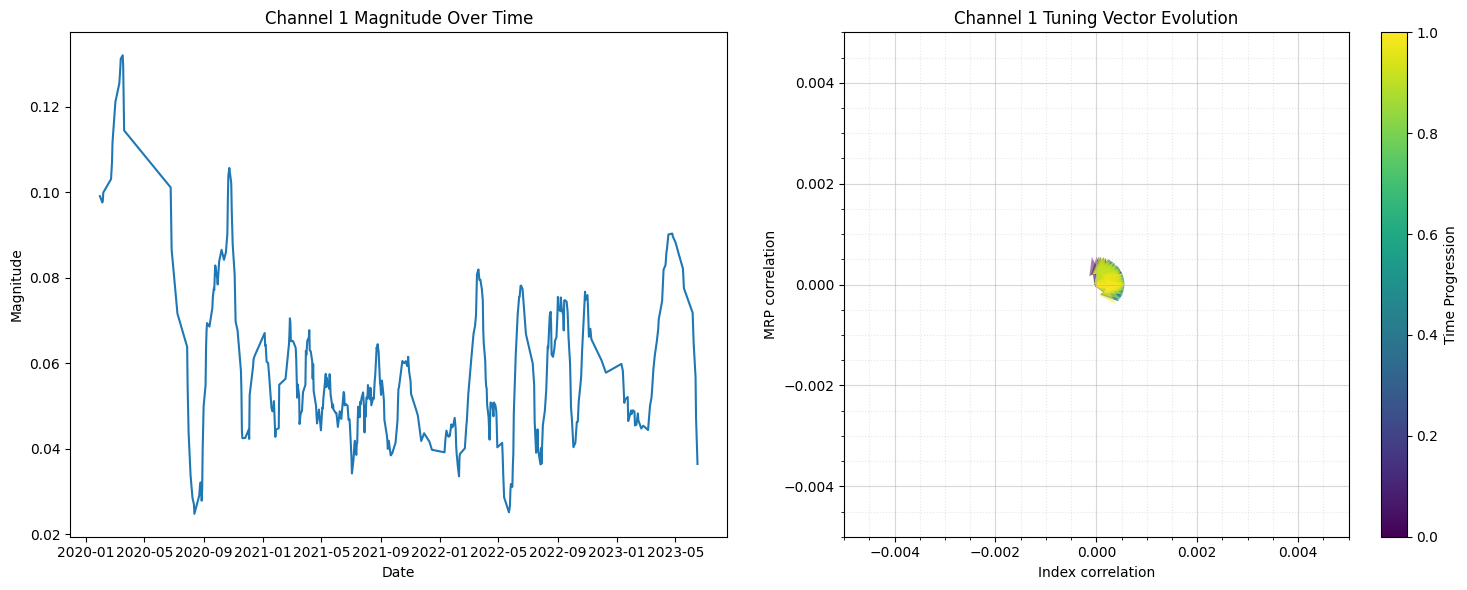

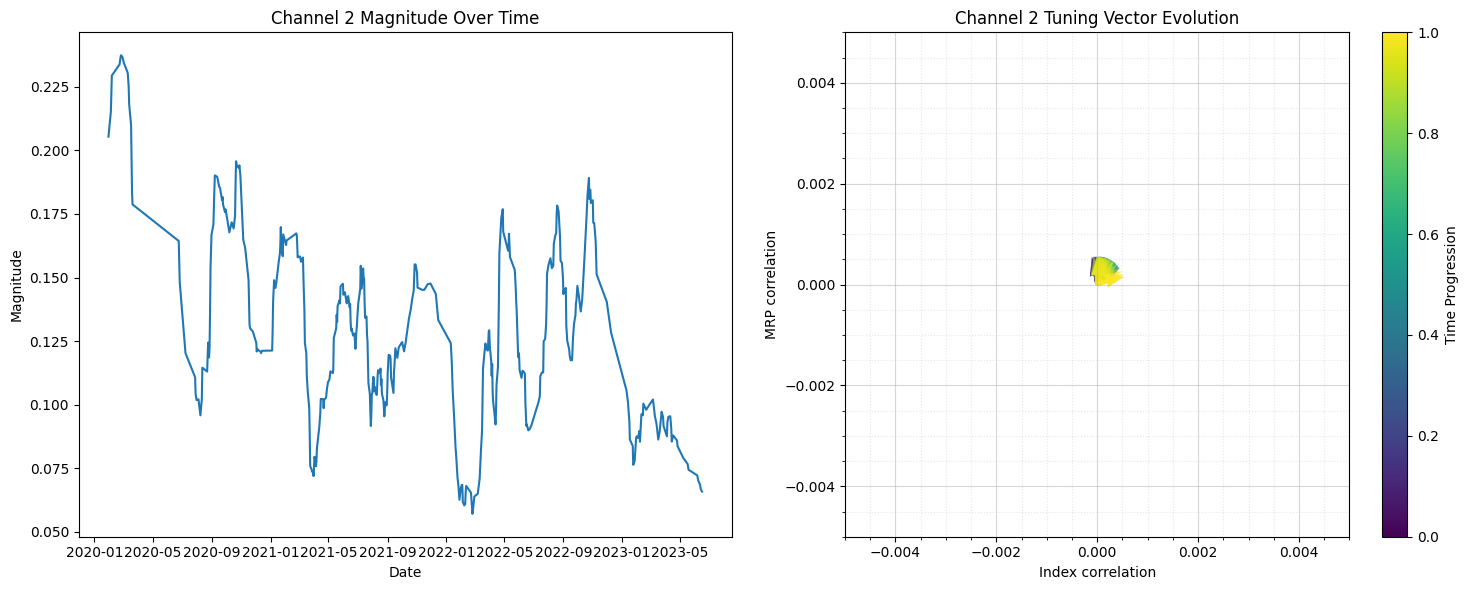

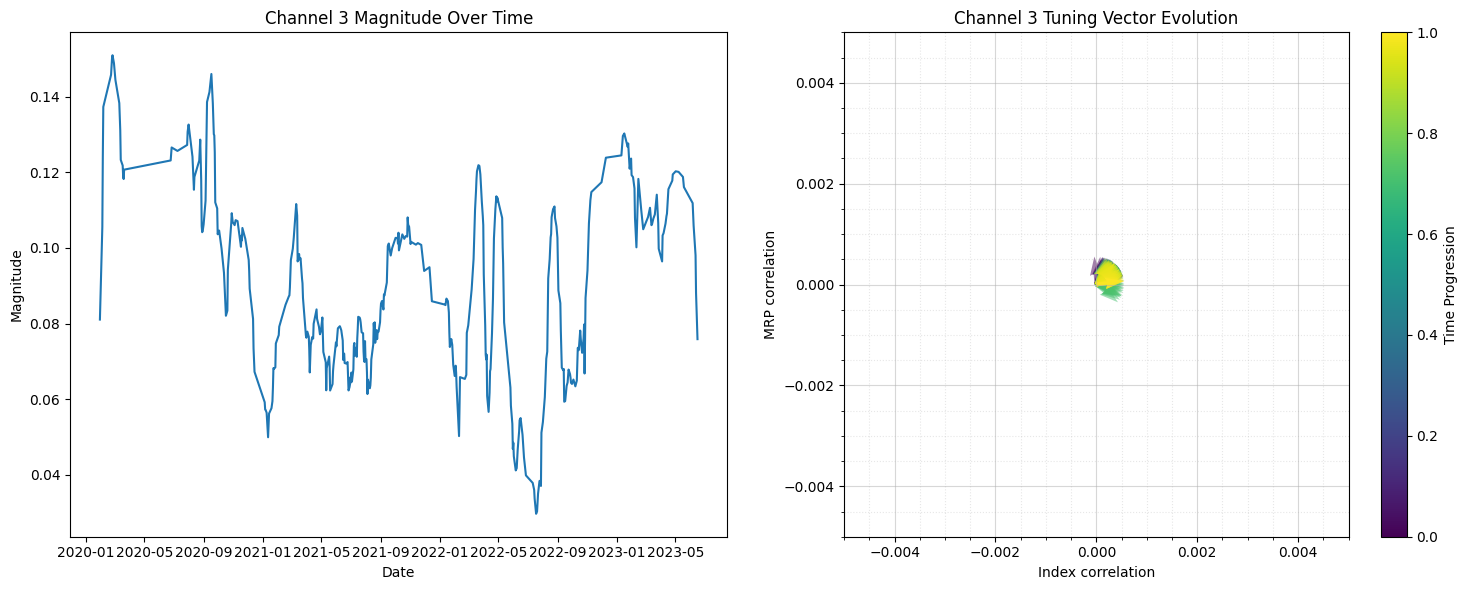

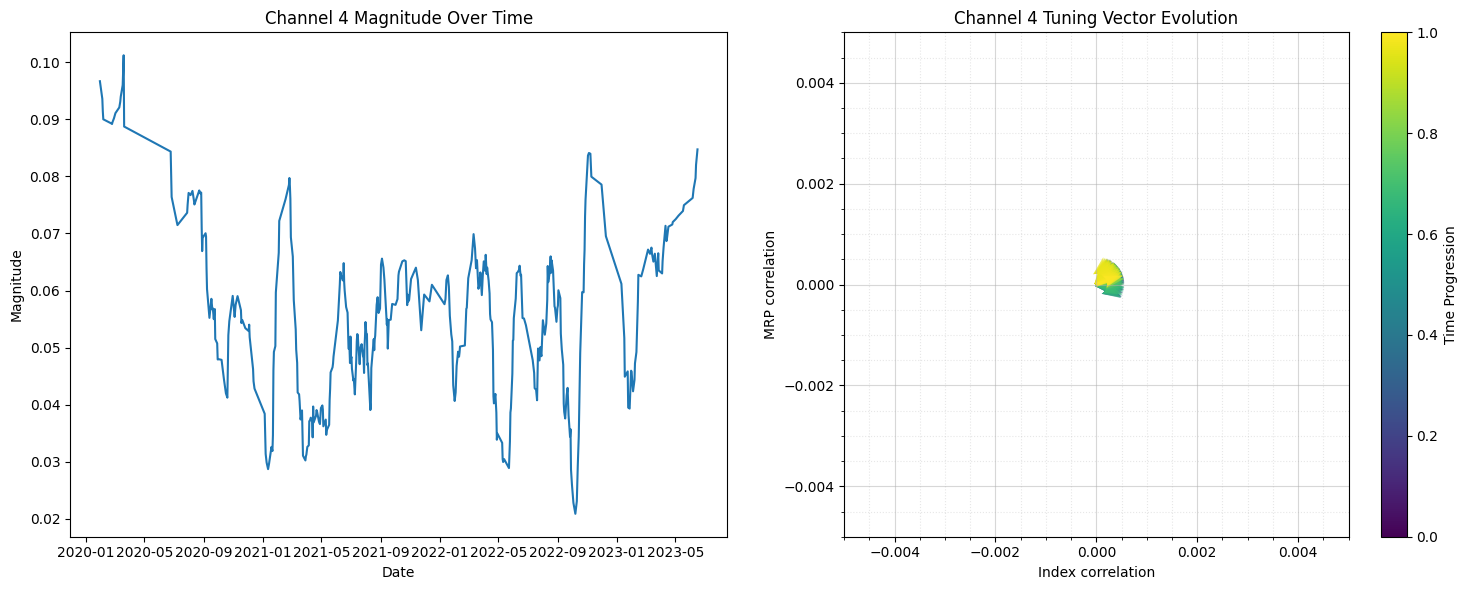

In [47]:
### VISUALIZATION ###
def plot_tuning_analysis(df_tuning, window_length=49, poly_order=3):
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Magnitude Plot
    ax1 = plt.subplot(311)
    for channel in df_tuning['magnitude'].columns[:80]:  # First 5 channels
        y = df_tuning['magnitude'][channel].values
        y_smooth = savgol_filter(y, window_length, poly_order)
        ax1.plot(df_tuning.index, y_smooth, label=channel)
    ax1.set_title('Tuning Magnitude Over Time')
    ax1.set_ylabel('Magnitude')
    # ax1.legend()
    
    # 2. Angle Plot
    ax2 = plt.subplot(312)
    for channel in df_tuning['angle'].columns[:80]:
        y = df_tuning['angle'][channel].values
        y_smooth = savgol_filter(y, window_length, poly_order)
        ax2.plot(df_tuning.index, y_smooth, label=channel)
    ax2.set_title('Tuning Angle Over Time')
    ax2.set_ylabel('Angle (degrees)')
    # ax2.legend()
    
    # 3. Polar Plot for Selected Time Points
    ax3 = plt.subplot(313, projection='polar')
    # Select a few time points to show evolution
    time_points = df_tuning.index[::len(df_tuning.index)//10][:20]  # 5 evenly spaced time points
    #time_points = df_tuning.index[135:155]  # 5 evenly spaced time points

    
    for idx, time_point in enumerate(time_points):
        angles = df_tuning['angle'].loc[time_point][80] #.values  # First 5 channels
        magnitudes = df_tuning['magnitude'].loc[time_point][80] #.values
        ax3.scatter(np.radians(angles), magnitudes, 
                   label=time_point.strftime('%Y-%m-%d'),
                   alpha=0.6, s=100)
    ax3.set_title('Tuning Direction and Magnitude\nat Different Time Points')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

def plot_channel_evolution(df_tuning, channel_num=0, window_length=23, poly_order=3):
    channel = f'sbp_channel_{channel_num}'
    
    # Get magnitude and angle data
    magnitude = df_tuning['magnitude'][channel].values
    angle = df_tuning['angle'][channel].values
    
    # Smooth the data
    magnitude_smooth = savgol_filter(magnitude, window_length, poly_order)
    angle_smooth = savgol_filter(angle, window_length, poly_order)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Time series plot
    ax1.plot(df_tuning.index, magnitude_smooth, label='Magnitude')
    ax1.set_title(f'Channel {channel_num} Magnitude Over Time')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Magnitude')
    
    # Vector plot
    times = np.linspace(0, 1, len(magnitude_smooth))
    colors = plt.cm.viridis(times)
    
    ax2.set_aspect('equal')
    for i in range(len(magnitude_smooth)-1):
        ax2.quiver(0, 0, 
                  magnitude_smooth[i] * np.cos(np.radians(angle_smooth[i])),
                  magnitude_smooth[i] * np.sin(np.radians(angle_smooth[i])),
                  color=colors[i], alpha=0.5)

    # Adjust axis limits to zoom in (much smaller range)
    ax2.set_xlim(-0.005, 0.005)  # Zoomed in 4x
    ax2.set_ylim(-0.005, 0.005)  # Zoomed in 4x
    
    # Add grid and minor grid for better readability
    ax2.grid(True, which='major', linestyle='-', alpha=0.5)
    ax2.grid(True, which='minor', linestyle=':', alpha=0.3)
    ax2.minorticks_on()
    
    # Add colorbar to show time progression
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
    cbar = plt.colorbar(sm, ax=ax2)
    cbar.set_label('Time Progression')
    
    ax2.set_title(f'Channel {channel_num} Tuning Vector Evolution')
    ax2.set_xlabel('Index correlation')
    ax2.set_ylabel('MRP correlation')
    
    plt.tight_layout()
    plt.show()

# Call the visualization functions
plot_tuning_analysis(df_tuning_mean_included)

# Plot evolution for first few channels
for i in range(5):
    plot_channel_evolution(df_tuning_mean_included, i)

/var/folders/vs/x5my52wn5jv64c7gz3gxk3th0000gn/T/ipykernel_49360/900312085.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', num_frames)


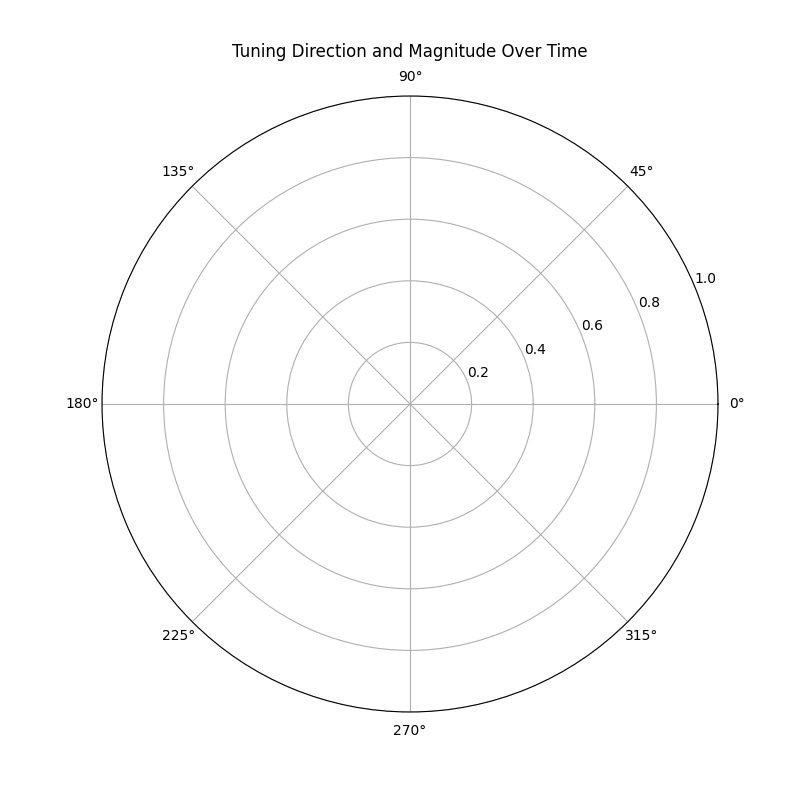

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm

def animate_tuning_with_history(df_tuning, history_window=10):
    # Data preparation
    time_points = df_tuning.index
    angles = np.radians(df_tuning['angle'].iloc[:, 80].values)  # Convert to radians
    magnitudes = df_tuning['magnitude'].iloc[:, 80].values
    num_frames = len(time_points)

    # Normalize magnitudes to fit on the plot
    max_magnitude = magnitudes.max()
    magnitudes = magnitudes / max_magnitude

    # Setup the polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
    ax.set_title('Tuning Direction and Magnitude Over Time', va='bottom')
    cmap = cm.get_cmap('viridis', num_frames)

    # Store history of vectors for fading effect
    history = []

    def update(frame):
        ax.clear()  # Clear the previous frame

        # Current vector
        angle = angles[frame]
        magnitude = magnitudes[frame]
        color = cmap(frame / num_frames)

        # Add current vector to history
        history.append((angle, magnitude, color))

        # Plot all vectors in history with fading effect
        for i, (h_angle, h_magnitude, h_color) in enumerate(history[-history_window:]):
            alpha = (i + 1) / history_window  # Fade out older vectors
            ax.quiver(0, 0, h_magnitude * np.cos(h_angle), h_magnitude * np.sin(h_angle),
                      angles='xy', scale_units='xy', scale=1, color=h_color, alpha=alpha)

        # Update title
        ax.set_title(f'Time: {time_points[frame].strftime("%Y-%m-%d")}', va='bottom')

        # Set the plot to center on 0 magnitude
        ax.set_ylim(0, 1)

    # Create the animation
    ani = FuncAnimation(fig, update, frames=num_frames, interval=100, repeat=True)

    # Display the animation
    plt.show()

    #return ani

# Call the function with your dataframe
ani = animate_tuning_with_history(df_tuning_mean_included)


/var/folders/vs/x5my52wn5jv64c7gz3gxk3th0000gn/T/ipykernel_28594/1455647487.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(np.unique(clusters)))


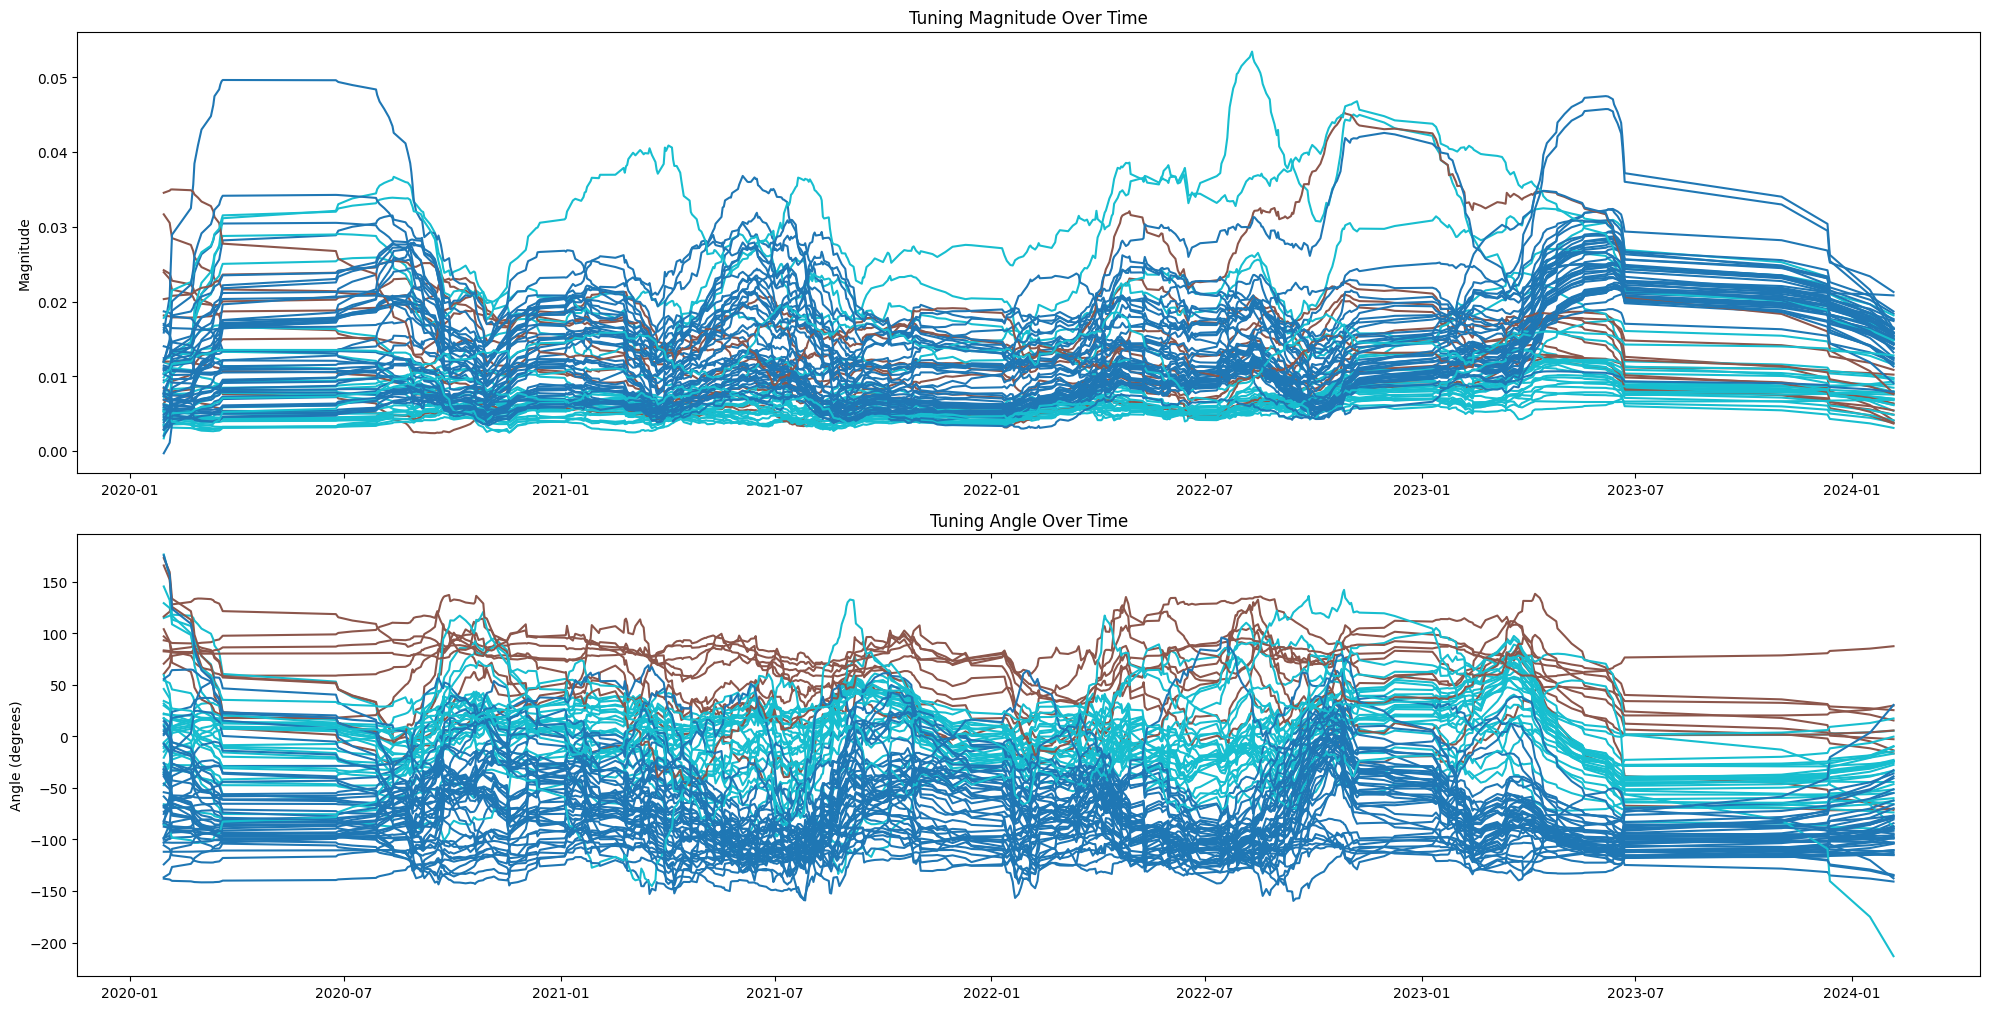

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def perform_pca_clustering(df_tuning, n_components=2, n_clusters=3):
    # Prepare data: concatenate smoothed magnitude and angle cross-correlations
    magnitude_data = df_tuning['magnitude'].apply(
        lambda x: savgol_filter(x.values, 49, 3), axis=0).T
    angle_data = df_tuning['angle'].apply(
        lambda x: savgol_filter(x.values, 49, 3), axis=0).T
    data = np.hstack([magnitude_data, angle_data])
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    
    # Perform clustering on PCA-transformed data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(pca_data)
    
    return clusters

def plot_tuning_analysis_with_clusters(df_tuning, clusters, window_length=49, poly_order=3):
    fig = plt.figure(figsize=(20, 15))
    
    # Define a colormap for clusters
    cmap = plt.cm.get_cmap('tab10', len(np.unique(clusters)))
    
    # 1. Magnitude Plot
    ax1 = plt.subplot(311)
    for i, channel in enumerate(df_tuning['magnitude'].columns[:80]):
        y = df_tuning['magnitude'][channel].values
        y_smooth = savgol_filter(y, window_length, poly_order)
        ax1.plot(df_tuning.index, y_smooth, color=cmap(clusters[i]), label=channel if i < 5 else None)
    ax1.set_title('Tuning Magnitude Over Time')
    ax1.set_ylabel('Magnitude')
    
    # 2. Angle Plot
    ax2 = plt.subplot(312)
    for i, channel in enumerate(df_tuning['angle'].columns[:80]):
        y = df_tuning['angle'][channel].values
        y_smooth = savgol_filter(y, window_length, poly_order)
        ax2.plot(df_tuning.index, y_smooth, color=cmap(clusters[i]), label=channel if i < 5 else None)
    ax2.set_title('Tuning Angle Over Time')
    ax2.set_ylabel('Angle (degrees)')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage
clusters = perform_pca_clustering(df_tuning)
plot_tuning_analysis_with_clusters(df_tuning, clusters)


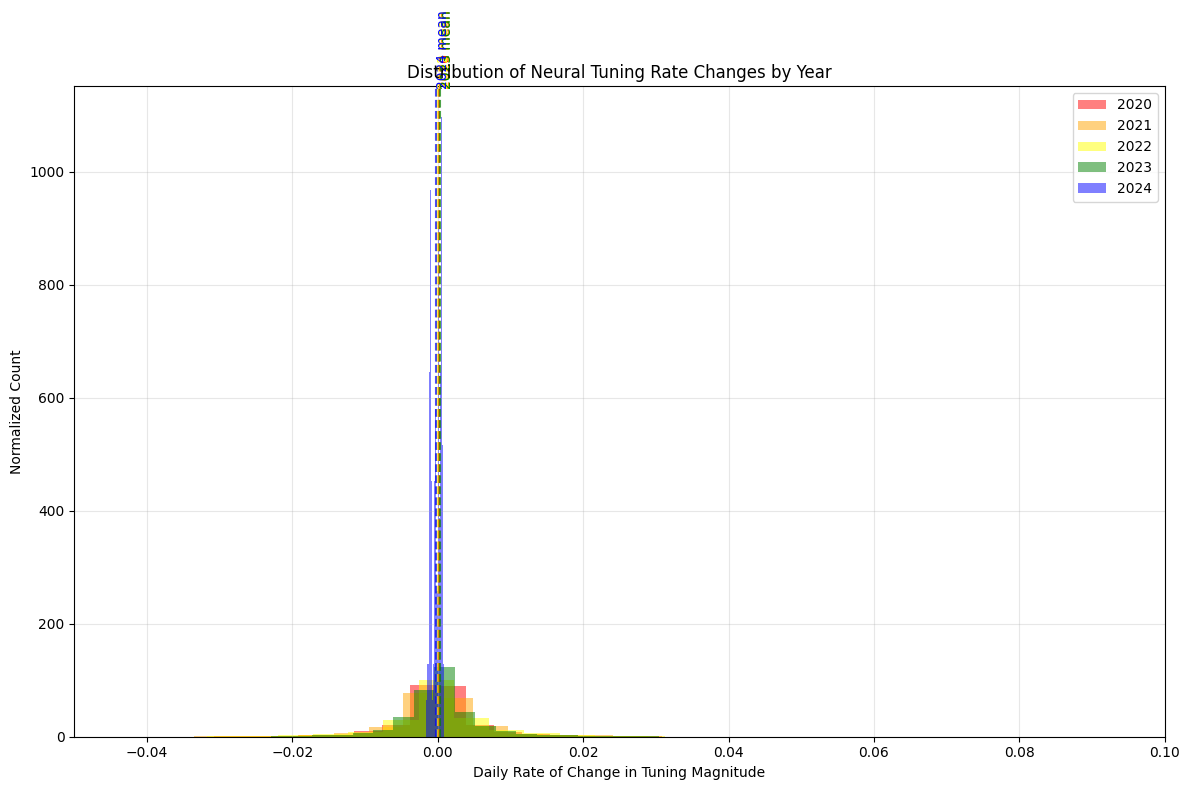

In [13]:
def plot_tuning_rate_distribution(df_tuning):
    # Calculate rate of change for magnitude
    rate_changes = {}
    
    for channel in df_tuning['magnitude'].columns:
        # Get magnitude data
        magnitude = df_tuning['magnitude'][channel]
        
        # Calculate daily rate of change
        daily_change = magnitude.diff() / (df_tuning.index.to_series().diff().dt.days)

        # # Compute time-weighted derivatives
        # derivatives = df_results.diff() / time_diff.values[:, np.newaxis]

        # # Compute rolling average of derivatives
        # window_size = 5  # Adjust as needed
        # rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()


        # Convert results to DataFrame
        # df_results = pd.DataFrame(results).T
        # df_results.index.name = 'Date'

        # # Sort by date
        # df_results.sort_index(inplace=True)

        # # Compute time differences in days
        # time_diff = df_results.index.to_series().diff().dt.total_seconds() / (24 * 3600)

        # # Compute time-weighted derivatives
        # derivatives = df_results.diff() / time_diff.values[:, np.newaxis]

        # # Compute rolling average of derivatives
        # window_size = 5  # Adjust as needed
        # rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
        
        # Group by year
        daily_change.index = pd.to_datetime(daily_change.index)
        years = daily_change.groupby(daily_change.index.year)
        
        # Store rates by year
        for year, rates in years:
            if year not in rate_changes:
                rate_changes[year] = []
            rate_changes[year].extend(rates.dropna().values)
    
    # Create histogram
    plt.figure(figsize=(12, 8))
    
    # Color scheme for different years
    colors = {'2020': 'red', '2021': 'orange', '2022': 'yellow', "2023": 'green', "2024": 'blue'}
    
    # Plot histogram for each year
    for year in sorted(rate_changes.keys()):
        plt.hist(rate_changes[year], bins=30, alpha=0.5, 
                label=f'{year}', color=colors.get(str(year), 'gray'),
                density=True)  # density=True for normalized comparison
    
    plt.xlabel('Daily Rate of Change in Tuning Magnitude')
    plt.ylabel('Normalized Count')
    plt.title('Distribution of Neural Tuning Rate Changes by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add mean lines
    for year in rate_changes:
        mean_rate = np.mean(rate_changes[year])
        plt.axvline(mean_rate, color=colors.get(str(year), 'gray'), 
                   linestyle='--', alpha=0.7)
        plt.text(mean_rate, plt.gca().get_ylim()[1], 
                f'{year} mean', rotation=90, 
                color=colors.get(str(year), 'gray'))
        
    plt.xlim(-0.05, 0.1)  # Adjust these values based on your actual rate ranges
    
    plt.tight_layout()
    plt.show()

plot_tuning_rate_distribution(df_tuning)



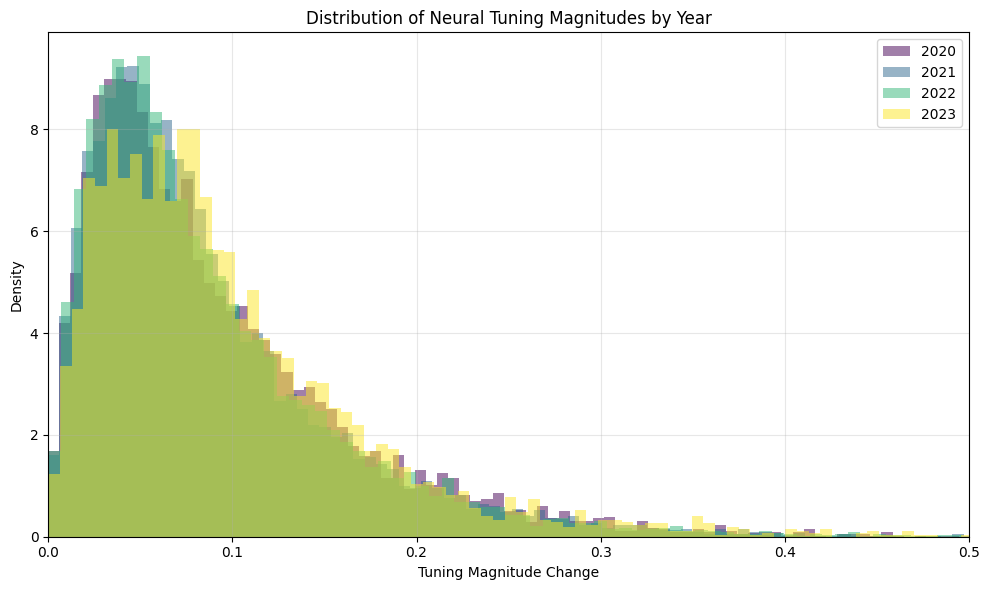

In [10]:
def plot_magnitude_distribution(df_tuning):
    # Collect magnitudes and years
    magnitudes = []
    years = []
    
    for channel in df_tuning['magnitude'].columns:
        # Get magnitude data
        channel_magnitudes = df_tuning['magnitude'][channel]
        
        # Store magnitudes and corresponding years
        for date, mag in channel_magnitudes.items():
            if not np.isnan(mag):
                magnitudes.append(mag)
                years.append(date.year)
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create histogram for each year
    unique_years = sorted(set(years))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))
    
    for year, color in zip(unique_years, colors):
        year_magnitudes = [m for m, y in zip(magnitudes, years) if y == year]
        
        # Calculate appropriate bin width
        range_min = 0
        range_max = max(year_magnitudes) if year_magnitudes else 0.1
        bin_width = (range_max - range_min) / 100  # Adjust this value to change bin size
        
        plt.hist(year_magnitudes, 
                bins=np.arange(range_min, range_max + bin_width, bin_width),
                alpha=0.5,
                color=color,
                label=str(year),
                density=True)
    
    plt.xlabel('Tuning Magnitude Change')
    plt.ylabel('Density')
    plt.title('Distribution of Neural Tuning Magnitudes by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set x-axis limits based on your data (from image, magnitudes are around 0.05-0.09)
    plt.xlim(0, 0.5)  # Adjust these values based on your actual magnitude ranges
    
    plt.tight_layout()
    plt.show()

plot_magnitude_distribution(df_tuning_mean_included)

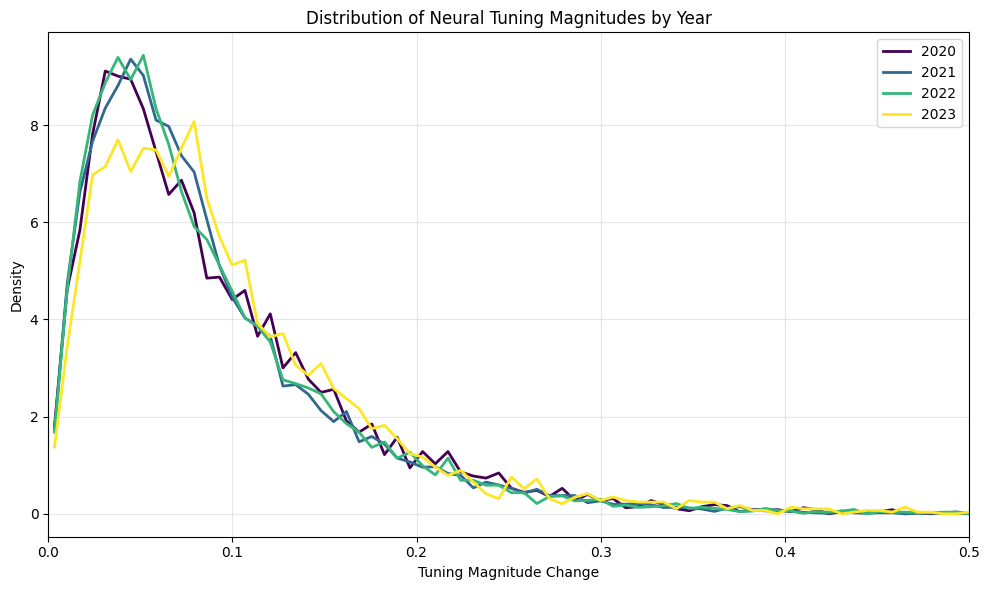

In [11]:
def plot_magnitude_distribution_outline(df_tuning):
    # Collect magnitudes and years
    magnitudes = []
    years = []
    
    for channel in df_tuning['magnitude'].columns:
        channel_magnitudes = df_tuning['magnitude'][channel]
        
        for date, mag in channel_magnitudes.items():
            if not np.isnan(mag):
                magnitudes.append(mag)
                years.append(date.year)
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create outline for each year
    unique_years = sorted(set(years))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))
    
    # Create bins for histogram
    range_min = 0
    range_max = max(magnitudes) if magnitudes else 0.1
    bin_width = (range_max - range_min) / 100  # Adjust for desired resolution
    bins = np.arange(range_min, range_max + bin_width, bin_width)

    for year, color in zip(unique_years, colors):
        year_magnitudes = [m for m, y in zip(magnitudes, years) if y == year]
        
        # Get histogram values for outline
        hist_values, _ = np.histogram(year_magnitudes, bins=bins, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Plot outline
        plt.plot(bin_centers, hist_values, color=color, linewidth=2, label=str(year))
    
    plt.xlabel('Tuning Magnitude Change')
    plt.ylabel('Density')
    plt.title('Distribution of Neural Tuning Magnitudes by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set x-axis limits based on your magnitude ranges
    plt.xlim(0, 0.5)  # Adjust based on your data
    
    plt.tight_layout()
    plt.show()
    
plot_magnitude_distribution_outline(df_tuning_mean_included)

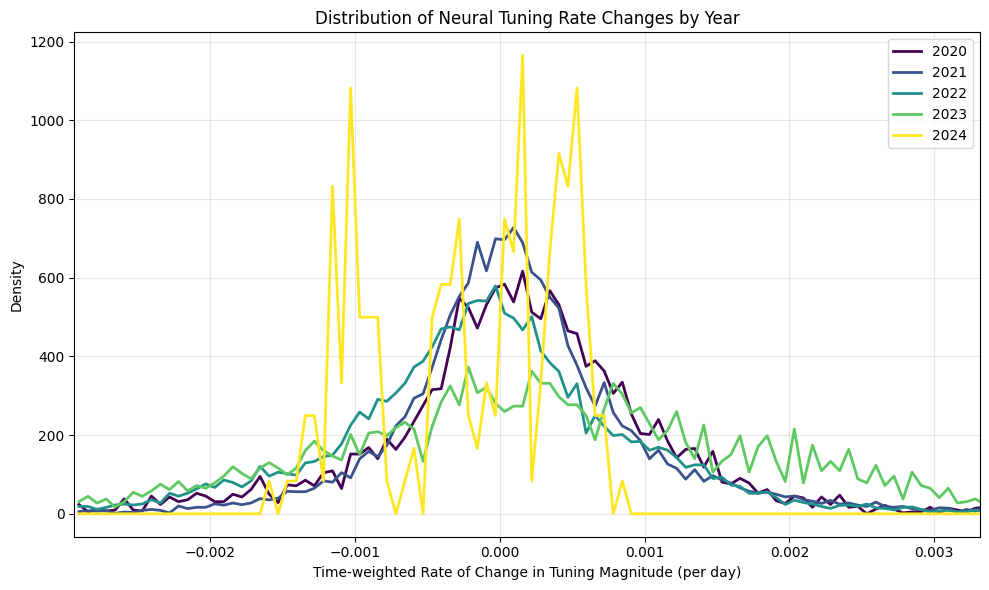

In [33]:
def plot_magnitude_distribution_outline_rolling(df_tuning):
    # Convert the nested dictionary structure to a DataFrame
    magnitudes_by_channel = {}
    
    for channel in df_tuning['magnitude'].columns:
        channel_magnitudes = df_tuning['magnitude'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)
    
    # Sort by date
    df_magnitudes.sort_index(inplace=True)
    
    # Compute time differences in days
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)
    
    # Compute time-weighted derivatives
    derivatives = df_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Compute rolling average of derivatives
    window_size = '30D'
    rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create outline for each year
    unique_years = sorted(set(df_magnitudes.index.year))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))
    
    # Create bins for histogram
    all_rates = rolling_avg.values.flatten()
    all_rates = all_rates[~np.isnan(all_rates)]
    
    range_min = np.percentile(all_rates, 1)  # 1st percentile to remove outliers
    range_max = np.percentile(all_rates, 99)  # 99th percentile to remove outliers
    bin_width = (range_max - range_min) / 100  # Adjust for desired resolution
    bins = np.arange(range_min, range_max + bin_width, bin_width)

    for year, color in zip(unique_years, colors):
        # Get rates for this year
        year_mask = rolling_avg.index.year == year
        year_rates = rolling_avg[year_mask].values.flatten()
        year_rates = year_rates[~np.isnan(year_rates)]
        
        if len(year_rates) > 0:
            # Get histogram values for outline
            hist_values, _ = np.histogram(year_rates, bins=bins, density=True)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            # Plot outline
            plt.plot(bin_centers, hist_values, color=color, linewidth=2, label=str(year))
    
    plt.xlabel('Time-weighted Rate of Change in Tuning Magnitude (per day)')
    plt.ylabel('Density')
    plt.title('Distribution of Neural Tuning Rate Changes by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set reasonable x-axis limits based on the data distribution
    plt.xlim(range_min, range_max)
    
    plt.tight_layout()
    plt.show()


plot_magnitude_distribution_outline_rolling(df_tuning)

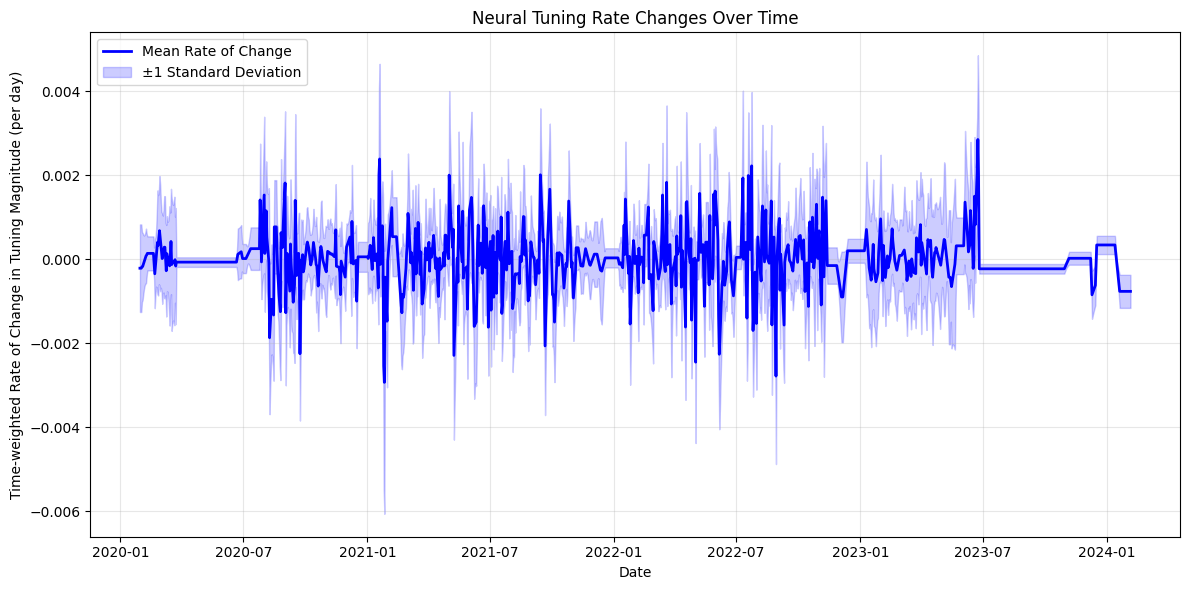

In [26]:
def plot_magnitude_distribution_continuous(df_tuning):
    # Convert the nested dictionary structure to a DataFrame
    magnitudes_by_channel = {}
    for channel in df_tuning['magnitude'].columns:
        channel_magnitudes = df_tuning['magnitude'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)
    
    # Sort by date
    df_magnitudes.sort_index(inplace=True)
    
    # Resample to daily frequency and interpolate
    df_magnitudes = df_magnitudes.resample('D').interpolate(method='linear')
    
    # Compute time differences in days
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)
    time_diff.iloc[0] = 1  # Handle the first NaN
    
    # Compute time-weighted derivatives
    derivatives = df_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Compute rolling average of derivatives
    window_size = '7D'  # Time-based rolling average
    rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Calculate mean and standard deviation across channels
    mean_values = rolling_avg.mean(axis=1)
    std_values = rolling_avg.std(axis=1)
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot mean line
    plt.plot(rolling_avg.index, mean_values, 
             color='blue', 
             label='Mean Rate of Change',
             linewidth=2)
    
    # Add standard deviation envelope
    plt.fill_between(rolling_avg.index,
                     mean_values - std_values,
                     mean_values + std_values,
                     color='blue', 
                     alpha=0.2,
                     label='±1 Standard Deviation')
    
    plt.xlabel('Date')
    plt.ylabel('Time-weighted Rate of Change in Tuning Magnitude (per day)')
    plt.title('Neural Tuning Rate Changes Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
plot_magnitude_distribution_continuous(df_tuning)

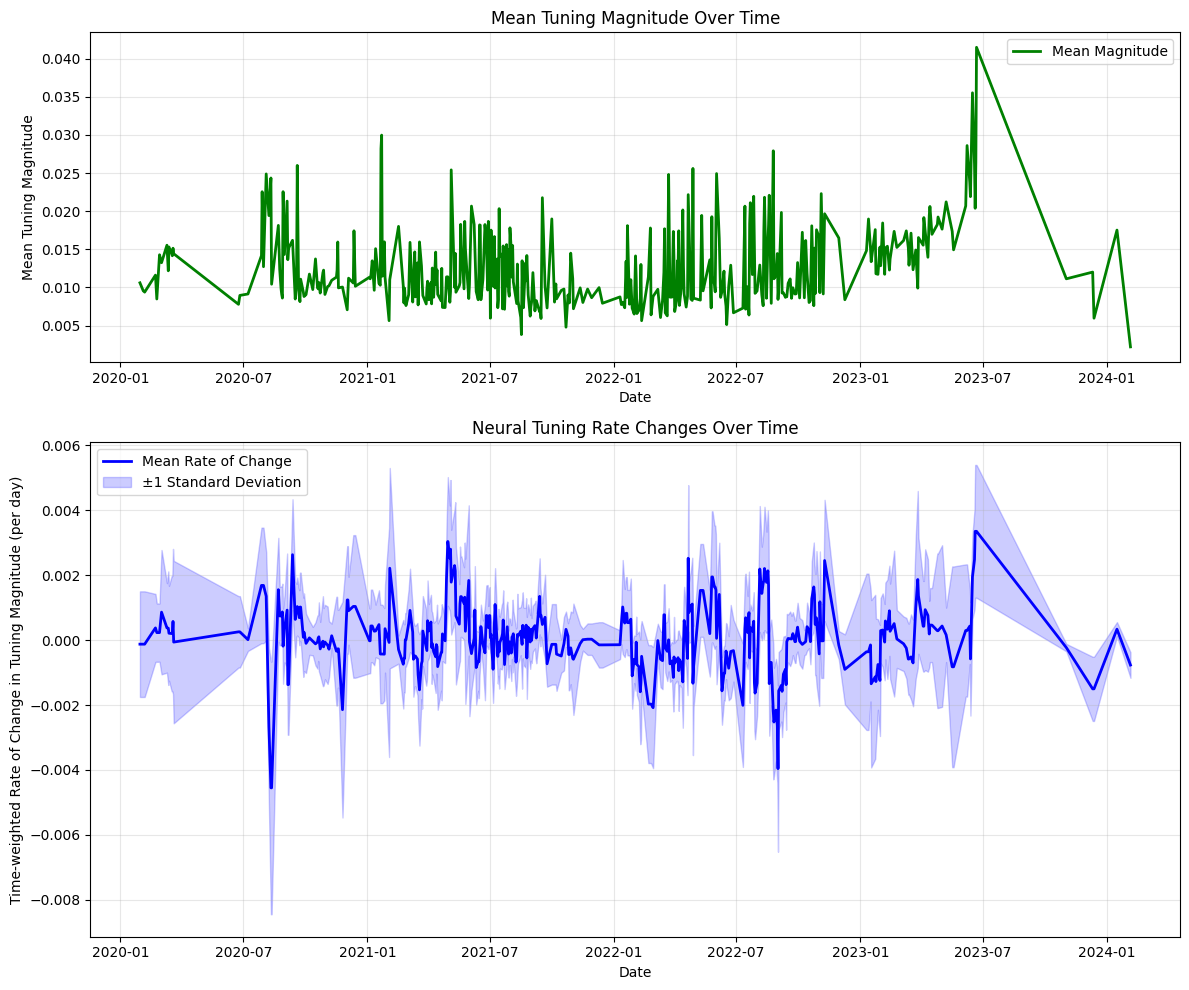

In [ ]:
def plot_magnitude_distribution_continuous_improved(df_tuning):
    # Convert the nested dictionary structure to a DataFrame
    magnitudes_by_channel = {}
    for channel in df_tuning['magnitude'].columns:
        channel_magnitudes = df_tuning['magnitude'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)
    
    # Sort by date
    df_magnitudes.sort_index(inplace=True)
    
    # Compute time differences in days
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)
    
    # Compute time-weighted derivatives
    derivatives = df_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Use time-based rolling window
    window_size = '14D'
    rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Calculate mean and std values
    mean_values = rolling_avg.mean(axis=1)
    std_values = rolling_avg.std(axis=1)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 1.5])
    
    # Plot mean magnitude over time in top subplot
    mean_magnitude = df_magnitudes.mean(axis=1)
    ax1.plot(df_magnitudes.index, mean_magnitude, 
             color='green', 
             linewidth=2,
             label='Mean Magnitude')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Tuning Magnitude')
    ax1.set_title('Mean Tuning Magnitude Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot rate of change in bottom subplot
    ax2.plot(rolling_avg.index, mean_values, 
             color='blue', 
             label='Mean Rate of Change',
             linewidth=2)
    ax2.fill_between(rolling_avg.index,
                     mean_values - std_values,
                     mean_values + std_values,
                     color='blue', 
                     alpha=0.2,
                     label='±1 Standard Deviation')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Time-weighted Rate of Change in Tuning Magnitude (per day)')
    ax2.set_title('Neural Tuning Rate Changes Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_magnitude_distribution_continuous_improved(df_tuning)


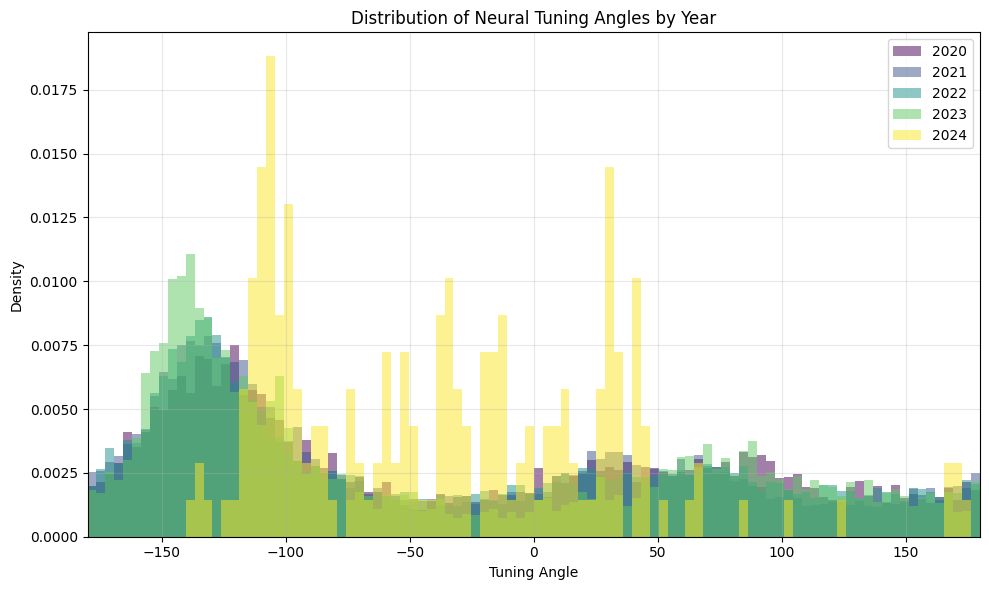

In [44]:
def plot_tuning_distribution(df_tuning):
    # Collect magnitudes and years
    magnitudes = []
    years = []
    
    for channel in df_tuning['angle'].columns:
        # Get magnitude data
        channel_magnitudes = df_tuning['angle'][channel]
        
        # Store magnitudes and corresponding years
        for date, mag in channel_magnitudes.items():
            if not np.isnan(mag):
                magnitudes.append(mag)
                years.append(date.year)
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create histogram for each year
    unique_years = sorted(set(years))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))
    
    for year, color in zip(unique_years, colors):
        year_magnitudes = [m for m, y in zip(magnitudes, years) if y == year]
        
        # Calculate appropriate bin width
        range_min = -180
        range_max = 180 #max(year_magnitudes) if year_magnitudes else 0.1
        bin_width = (range_max - range_min) / 100  # Adjust this value to change bin size
        
        plt.hist(year_magnitudes, 
                bins=np.arange(range_min, range_max + bin_width, bin_width),
                alpha=0.5,
                color=color,
                label=str(year),
                density=True)
    
    plt.xlabel('Tuning Angle')
    plt.ylabel('Density')
    plt.title('Distribution of Neural Tuning Angles by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set x-axis limits based on your data (from image, magnitudes are around 0.05-0.09)
    plt.xlim(-180, 180)  # Adjust these values based on your actual magnitude ranges
    
    plt.tight_layout()
    plt.show()

plot_tuning_distribution(df_tuning)

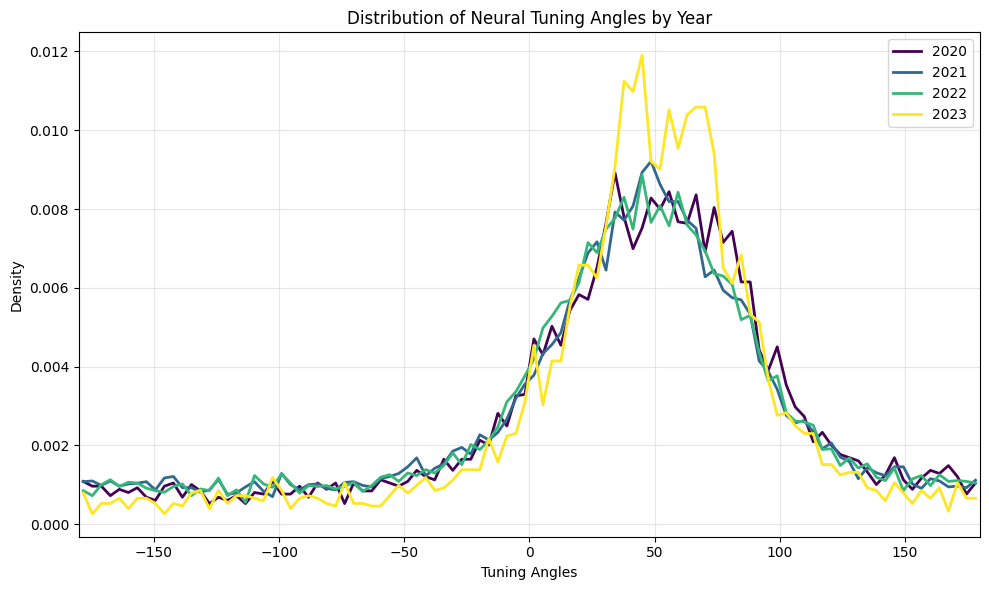

In [19]:
def plot_angle_distribution_outline(df_tuning):
    # Collect magnitudes and years
    magnitudes = []
    years = []
    
    for channel in df_tuning['angle'].columns:
        channel_magnitudes = df_tuning['angle'][channel]
        
        for date, mag in channel_magnitudes.items():
            if not np.isnan(mag):
                magnitudes.append(mag)
                years.append(date.year)
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create outline for each year
    unique_years = sorted(set(years))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))
    
    # Create bins for histogram
    range_min = -180
    range_max = 180 #max(magnitudes) if magnitudes else 0.1
    bin_width = (range_max - range_min) / 100  # Adjust for desired resolution
    bins = np.arange(range_min, range_max + bin_width, bin_width)

    for year, color in zip(unique_years, colors):
        year_magnitudes = [m for m, y in zip(magnitudes, years) if y == year]
        
        # Get histogram values for outline
        hist_values, _ = np.histogram(year_magnitudes, bins=bins, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Plot outline
        plt.plot(bin_centers, hist_values, color=color, linewidth=2, label=str(year))
    
    plt.xlabel('Tuning Angles')
    plt.ylabel('Density')
    plt.title('Distribution of Neural Tuning Angles by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set x-axis limits based on your magnitude ranges
    plt.xlim(-180, 180)  # Adjust based on your data
    
    plt.tight_layout()
    plt.show()
    
plot_angle_distribution_outline(df_tuning_mean_included)

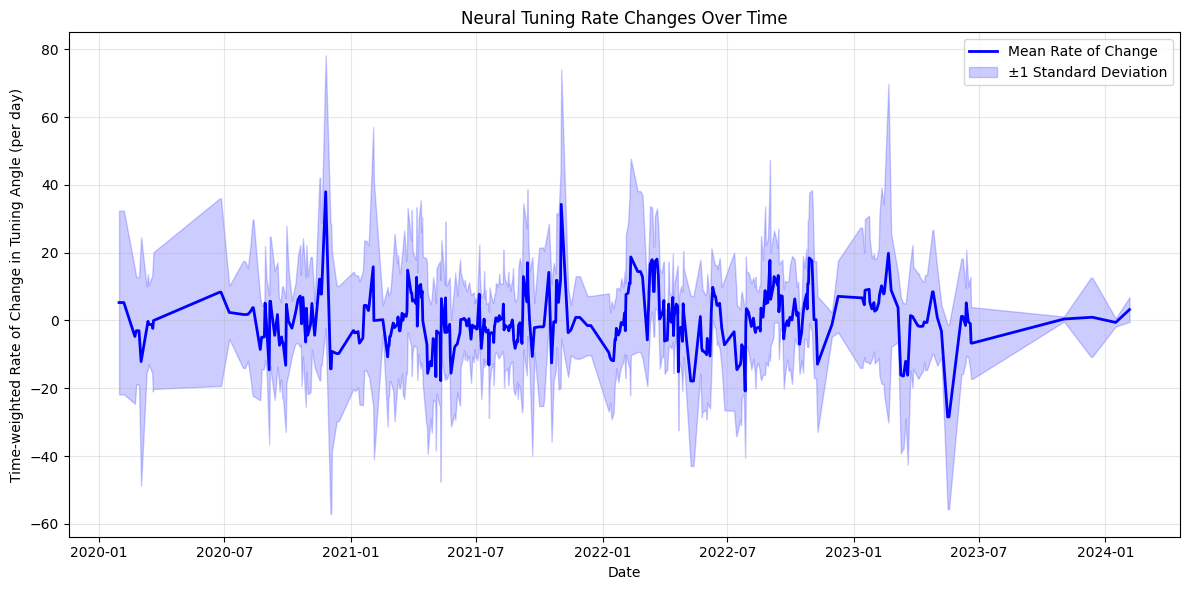

In [45]:
def plot_angle_distribution_continuous_improved(df_tuning):
    # Convert the nested dictionary structure to a DataFrame
    magnitudes_by_channel = {}
    for channel in df_tuning['angle'].columns:
        channel_magnitudes = df_tuning['angle'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)
    
    # Sort by date
    df_magnitudes.sort_index(inplace=True)
    
    # Compute time differences in days
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)
    
    # Compute time-weighted derivatives
    derivatives = df_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Use time-based rolling window instead of observation-based
    window_size = '14D'  # 7-day window
    rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Rest of the plotting code remains the same
    mean_values = rolling_avg.mean(axis=1)
    std_values = rolling_avg.std(axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(rolling_avg.index, mean_values, 
            color='blue', 
            label='Mean Rate of Change',
            linewidth=2)
    plt.fill_between(rolling_avg.index,
                    mean_values - std_values,
                    mean_values + std_values,
                    color='blue', 
                    alpha=0.2,
                    label='±1 Standard Deviation')
    
    plt.xlabel('Date')
    plt.ylabel('Time-weighted Rate of Change in Tuning Angle (per day)')
    plt.title('Neural Tuning Rate Changes Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_angle_distribution_continuous_improved(df_tuning)

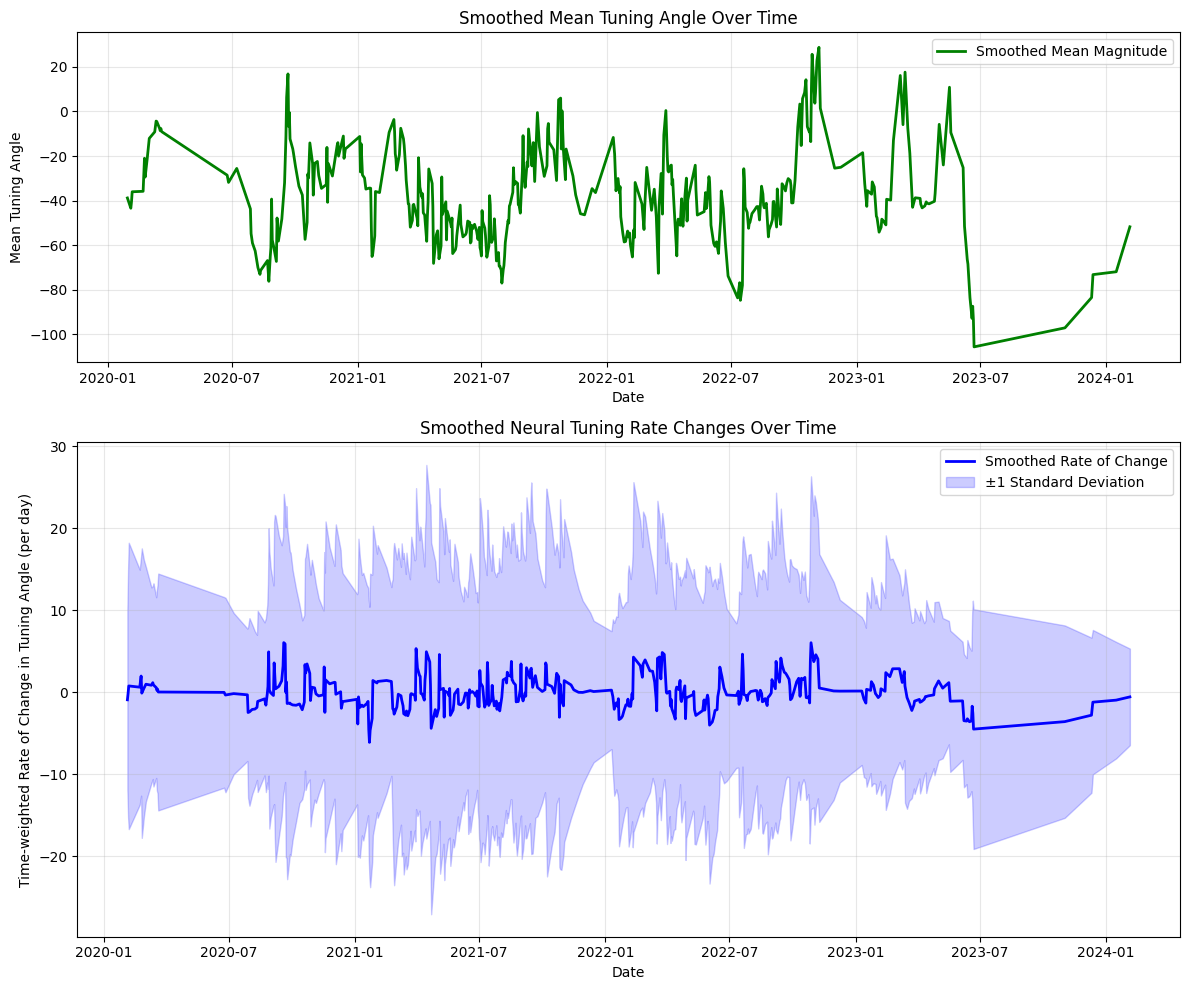

In [ ]:
def plot_angle_distribution_continuous_improved(df_tuning):
    # Convert and prepare data as before
    magnitudes_by_channel = {}
    for channel in df_tuning['angle'].columns:
        channel_magnitudes = df_tuning['angle'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)
    df_magnitudes.sort_index(inplace=True)
    
    # Apply exponential smoothing to the raw magnitude data
    alpha = 0.3  # smoothing factor
    smoothed_magnitudes = df_magnitudes.ewm(alpha=alpha).mean()
    
    # Calculate time-weighted derivatives with smoothing
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)
    derivatives = smoothed_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Apply adaptive bandwidth local linear regression for rate changes
    from scipy.stats import gaussian_kde
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 1.5])
    
    # Top subplot: Smoothed magnitude
    mean_magnitude = smoothed_magnitudes.mean(axis=1)
    ax1.plot(smoothed_magnitudes.index, mean_magnitude,
             color='green',
             linewidth=2,
             label='Smoothed Mean Magnitude')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Tuning Angle')
    ax1.set_title('Smoothed Mean Tuning Angle Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Bottom subplot: Smoothed rate of change
    mean_derivatives = derivatives.mean(axis=1)
    std_derivatives = derivatives.std(axis=1)
    
    # Apply double exponential smoothing to derivatives
    smoothed_derivatives = mean_derivatives.ewm(alpha=0.2, adjust=False).mean()
    smoothed_std = std_derivatives.ewm(alpha=0.2, adjust=False).mean()
    
    ax2.plot(derivatives.index, smoothed_derivatives,
             color='blue',
             label='Smoothed Rate of Change',
             linewidth=2)
    ax2.fill_between(derivatives.index,
                     smoothed_derivatives - smoothed_std,
                     smoothed_derivatives + smoothed_std,
                     color='blue',
                     alpha=0.2,
                     label='±1 Standard Deviation')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Time-weighted Rate of Change in Tuning Angle (per day)')
    ax2.set_title('Smoothed Neural Tuning Rate Changes Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_angle_distribution_continuous_improved(df_tuning_mean_included)


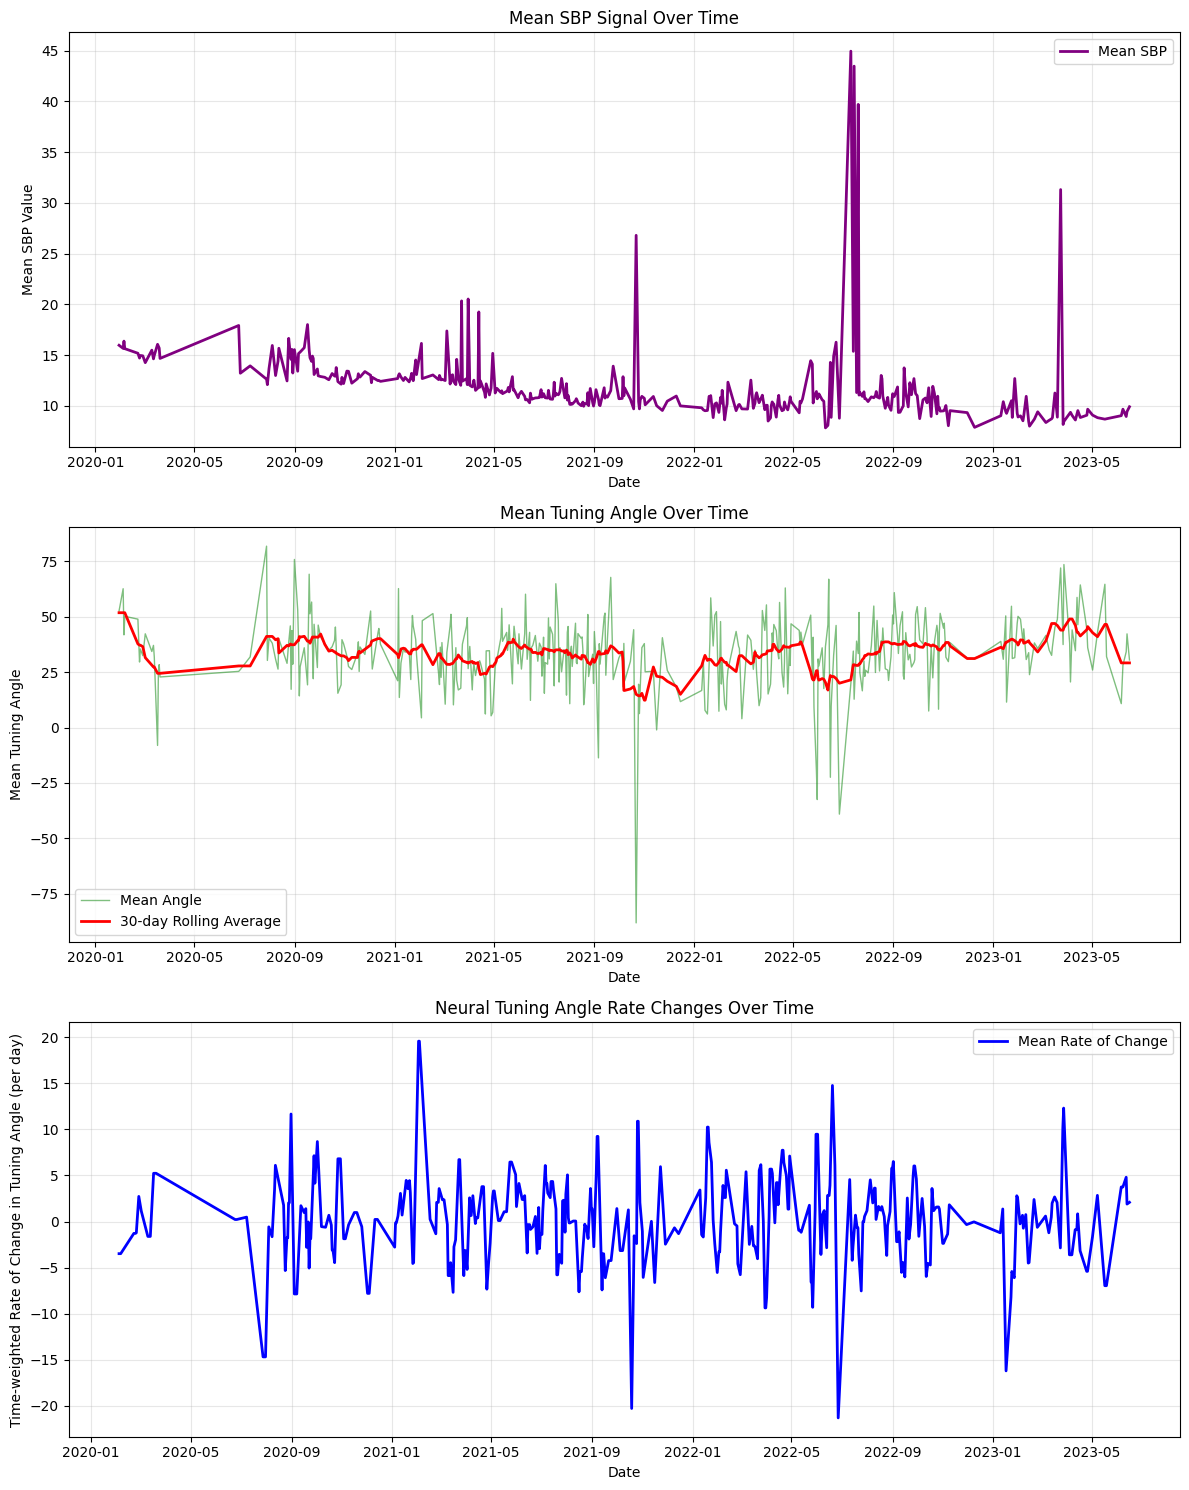

In [29]:
def plot_angle_distribution_continuous_improved(df_tuning):
    # Convert the nested dictionary structure to a DataFrame
    magnitudes_by_channel = {}
    for channel in df_tuning['angle'].columns:
        channel_magnitudes = df_tuning['angle'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)[:405]
    
    # Sort by date
    df_magnitudes.sort_index(inplace=True)
    
    # Compute time differences in days
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)
    
    # Compute time-weighted derivatives
    derivatives = df_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Use time-based rolling window
    window_size = '7D'
    rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Calculate mean and std values
    mean_values = rolling_avg.mean(axis=1)
    std_values = rolling_avg.std(axis=1)
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), height_ratios=[1, 1, 1])
    
    # Plot mean magnitude over time in top subplot
    mean_magnitude = df_magnitudes.mean(axis=1)
    ax2.plot(df_magnitudes.index, mean_magnitude, 
             color='green', 
             linewidth=1,
             alpha=0.5,
             label='Mean Angle')
    
    # Add 30-day rolling average trend line
    rolling_mean = mean_magnitude.rolling(window='30D', center=True, min_periods=1).mean()
    ax2.plot(df_magnitudes.index, rolling_mean,
             color='red',
             linewidth=2,
             label='30-day Rolling Average')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Mean Tuning Angle')
    ax2.set_title('Mean Tuning Angle Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot rate of change in middle subplot
    ax3.plot(rolling_avg.index, mean_values, 
             color='blue', 
             label='Mean Rate of Change',
             linewidth=2)
    
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Time-weighted Rate of Change in Tuning Angle (per day)')
    ax3.set_title('Neural Tuning Angle Rate Changes Over Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot mean SBP signal over time in bottom subplot
    mean_sbps = df_tuning['mean_sbps'].mean(axis=1)
    ax1.plot(df_tuning.index[:405], mean_sbps[:405], 
             color='purple', 
             linewidth=2,
             label='Mean SBP')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean SBP Value')
    ax1.set_title('Mean SBP Signal Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    plt.tight_layout()
    plt.show()

plot_angle_distribution_continuous_improved(df_tuning_mean_included)


In [30]:
def calculate_magnitude_changes(df_tuning):
    # Convert the nested dictionary structure to a DataFrame
    magnitudes_by_channel = {}
    for channel in df_tuning['magnitude'].columns:
        channel_magnitudes = df_tuning['magnitude'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)[:405]
    df_magnitudes.sort_index(inplace=True)
    
    # Calculate mean magnitude over time
    mean_magnitude = df_magnitudes.mean(axis=1)
    
    # Calculate weekly changes using absolute differences
    weekly_changes = mean_magnitude.resample('D').mean().diff() #.abs()
    average_weekly_change = weekly_changes.mean()
    
    # Calculate month-to-month changes using absolute differences
    monthly_changes = mean_magnitude.resample('ME').mean().diff() #.abs()
    average_monthly_change = monthly_changes.mean()
    
    # Calculate standard deviations of the changes
    weekly_std = weekly_changes.std()
    monthly_std = monthly_changes.std()
    
    return {
        'weekly_mean': average_weekly_change,
        'monthly_mean': average_monthly_change,
        'weekly_std': weekly_std,
        'monthly_std': monthly_std
    }

# Usage:
changes = calculate_magnitude_changes(df_tuning_mean_included)
print(f"Average Weekly Change: {changes['weekly_mean']:.4f} ± {changes['weekly_std']:.4f}")
print(f"Average Monthly Change: {changes['monthly_mean']:.4f} ± {changes['monthly_std']:.4f}")


Average Weekly Change: 0.0011 ± 0.0280
Average Monthly Change: 0.0019 ± 0.0154


In [58]:
def calculate_magnitude_changes(df_tuning):
    magnitudes_by_channel = {}
    for channel in df_tuning['angle'].columns:
        channel_magnitudes = df_tuning['angle'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)[:405]
    df_magnitudes.sort_index(inplace=True)
    
    # Calculate changes for each channel
    daily_changes = df_magnitudes.resample('D').median().diff().abs()
    mean_daily_changes = daily_changes.median()
    
    monthly_changes = df_magnitudes.resample('ME').median().diff().abs()
    mean_monthly_changes = monthly_changes.median()
    
    # Calculate standard deviations
    daily_std = daily_changes.std()
    monthly_std = monthly_changes.std()
    
    return {
        'daily_mean': mean_daily_changes,
        'monthly_mean': mean_monthly_changes,
        'daily_std': daily_std,
        'monthly_std': monthly_std
    }

def plot_daily_changes(daily_changes):
    plt.figure(figsize=(12, 6))
    for channel in daily_changes.columns:
        plt.plot(daily_changes.index, daily_changes[channel], label=channel)
    
    plt.title('Day-to-Day Magnitude Changes by Channel')
    plt.xlabel('Date')
    plt.ylabel('Magnitude Change')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_monthly_heatmap(monthly_changes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(monthly_changes.pivot_table(
        index=monthly_changes.index.month,
        columns=monthly_changes.columns,
        values=monthly_changes.values),
        cmap='RdYlBu_r',
        center=0,
        annot=True
    )
    plt.title('Monthly Magnitude Changes by Channel')
    plt.xlabel('Channel')
    plt.ylabel('Month')
    plt.tight_layout()
    plt.show()


def plot_combined_changes(daily_changes, monthly_changes):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Daily changes
    for channel in daily_changes.columns:
        ax1.plot(daily_changes.index, daily_changes[channel], label=channel)
    ax1.set_title('Daily Changes')
    ax1.legend(bbox_to_anchor=(1.05, 1))
    ax1.grid(True)
    
    # Monthly changes
    for channel in monthly_changes.columns:
        ax2.plot(monthly_changes.index, monthly_changes[channel], 
                marker='o', label=channel)
    ax2.set_title('Monthly Changes')
    ax2.legend(bbox_to_anchor=(1.05, 1))
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

output_dict = calculate_magnitude_changes(df_tuning_mean_included)

print("Mean Day-to-Day Change: ", output_dict["daily_mean"].mean(), "Mean Month-to-Month Change: ", output_dict["monthly_mean"].mean())



Mean Day-to-Day Change:  51.0689441178231 Mean Month-to-Month Change:  21.389747388974282


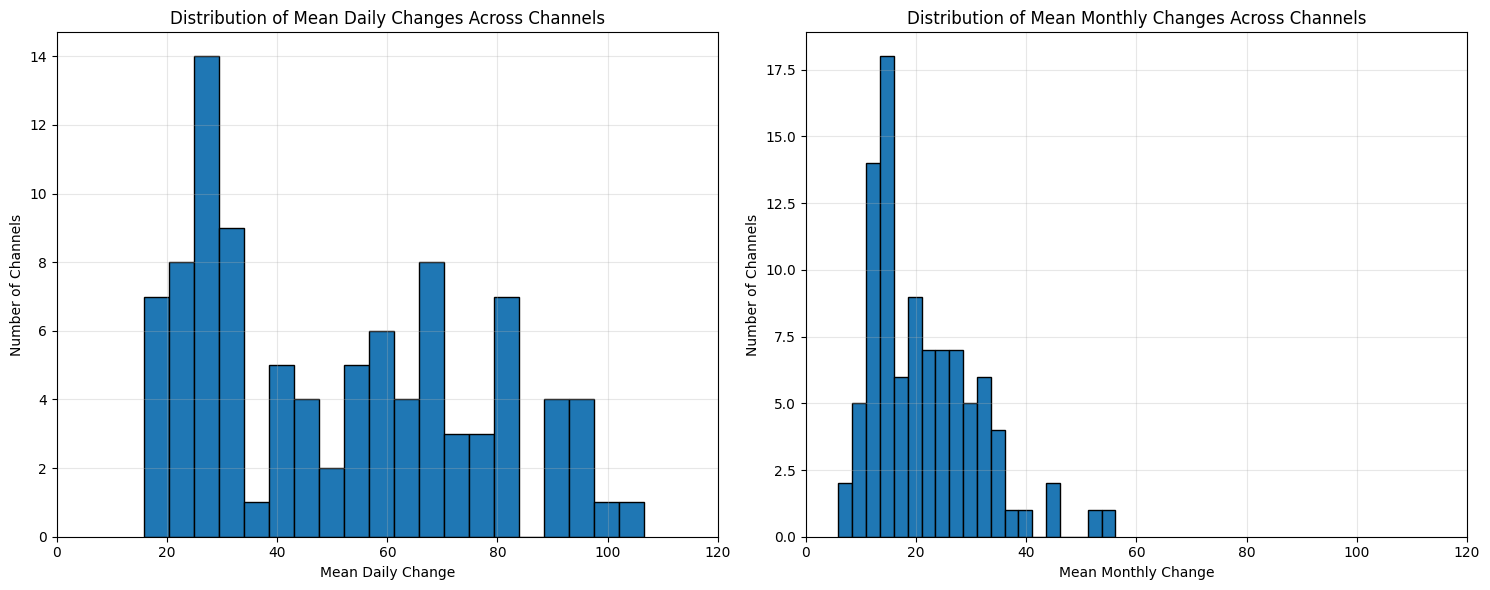


Daily Changes Summary:
Mean: 51.0689
Std: 24.7532
Min: 15.8253
Max: 106.5702

Monthly Changes Summary:
Mean: 21.3897
Std: 9.8609
Min: 5.9010
Max: 56.1836


In [59]:
def plot_change_distributions(df_tuning):
    # Calculate changes
    output_dict = calculate_magnitude_changes(df_tuning)
    daily_means = output_dict['daily_mean']
    monthly_means = output_dict['monthly_mean']
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Daily changes histogram
    ax1.hist(daily_means, bins=20, edgecolor='black')
    ax1.set_title('Distribution of Mean Daily Changes Across Channels')
    ax1.set_xlabel('Mean Daily Change')
    ax1.set_ylabel('Number of Channels')
    ax1.set_xlim(0, 120)  # Set x-axis range
    ax1.grid(True, alpha=0.3)
    
    # Monthly changes histogram
    ax2.hist(monthly_means, bins=20, edgecolor='black')
    ax2.set_title('Distribution of Mean Monthly Changes Across Channels')
    ax2.set_xlabel('Mean Monthly Change')
    ax2.set_ylabel('Number of Channels')
    ax2.set_xlim(0, 120)  # Set x-axis range
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nDaily Changes Summary:")
    print(f"Mean: {daily_means.mean():.4f}")
    print(f"Std: {daily_means.std():.4f}")
    print(f"Min: {daily_means.min():.4f}")
    print(f"Max: {daily_means.max():.4f}")
    
    print("\nMonthly Changes Summary:")
    print(f"Mean: {monthly_means.mean():.4f}")
    print(f"Std: {monthly_means.std():.4f}")
    print(f"Min: {monthly_means.min():.4f}")
    print(f"Max: {monthly_means.max():.4f}")

# Call the function
plot_change_distributions(df_tuning_mean_included)


In [ ]:

# PLOT HOW CLUSTERS OF CHANNELS CHANGE OVER TIME

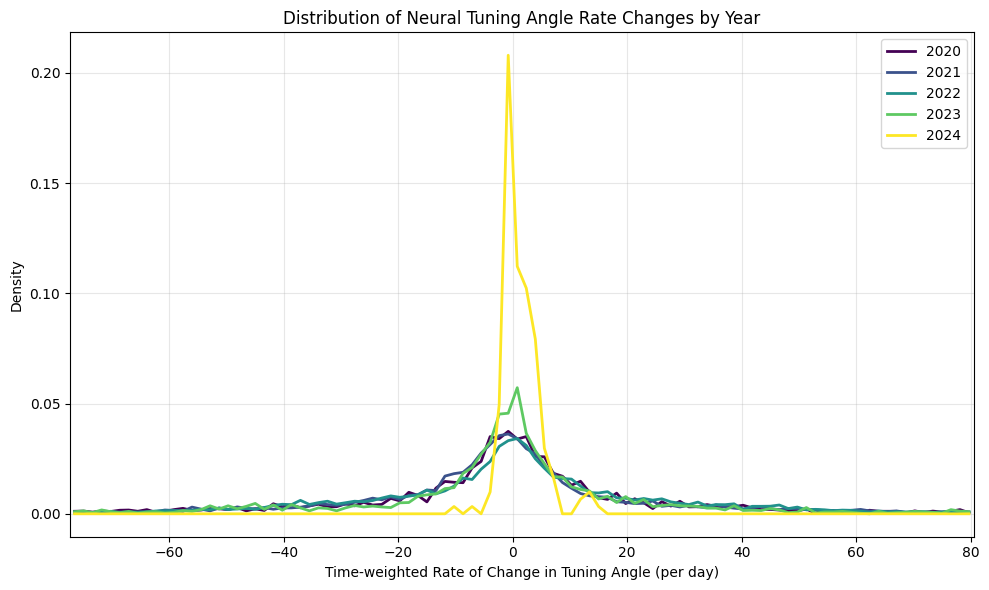

In [47]:
def plot_tuning_distribution_outline_rolling(df_tuning):
    # Convert the nested dictionary structure to a DataFrame
    magnitudes_by_channel = {}
    
    for channel in df_tuning['angle'].columns:
        channel_magnitudes = df_tuning['angle'][channel]
        magnitudes_by_channel[channel] = channel_magnitudes
    
    df_magnitudes = pd.DataFrame(magnitudes_by_channel)
    
    # Sort by date
    df_magnitudes.sort_index(inplace=True)
    
    # Compute time differences in days
    time_diff = df_magnitudes.index.to_series().diff().dt.total_seconds() / (24 * 3600)
    
    # Compute time-weighted derivatives
    derivatives = df_magnitudes.diff() / time_diff.values[:, np.newaxis]
    
    # Compute rolling average of derivatives
    window_size = '7D'
    rolling_avg = derivatives.rolling(window=window_size, center=True, min_periods=1).mean()
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Create outline for each year
    unique_years = sorted(set(df_magnitudes.index.year))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_years)))
    
    # Create bins for histogram
    all_rates = rolling_avg.values.flatten()
    all_rates = all_rates[~np.isnan(all_rates)]
    
    range_min = np.percentile(all_rates, 1)  # 1st percentile to remove outliers
    range_max = np.percentile(all_rates, 99)  # 99th percentile to remove outliers
    bin_width = (range_max - range_min) / 100  # Adjust for desired resolution
    bins = np.arange(range_min, range_max + bin_width, bin_width)

    for year, color in zip(unique_years, colors):
        # Get rates for this year
        year_mask = rolling_avg.index.year == year
        year_rates = rolling_avg[year_mask].values.flatten()
        year_rates = year_rates[~np.isnan(year_rates)]
        
        if len(year_rates) > 0:
            # Get histogram values for outline
            hist_values, _ = np.histogram(year_rates, bins=bins, density=True)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            # Plot outline
            plt.plot(bin_centers, hist_values, color=color, linewidth=2, label=str(year))
    
    plt.xlabel('Time-weighted Rate of Change in Tuning Angle (per day)')
    plt.ylabel('Density')
    plt.title('Distribution of Neural Tuning Angle Rate Changes by Year')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set reasonable x-axis limits based on the data distribution
    plt.xlim(range_min, range_max)
    
    plt.tight_layout()
    plt.show()


plot_tuning_distribution_outline_rolling(df_tuning)

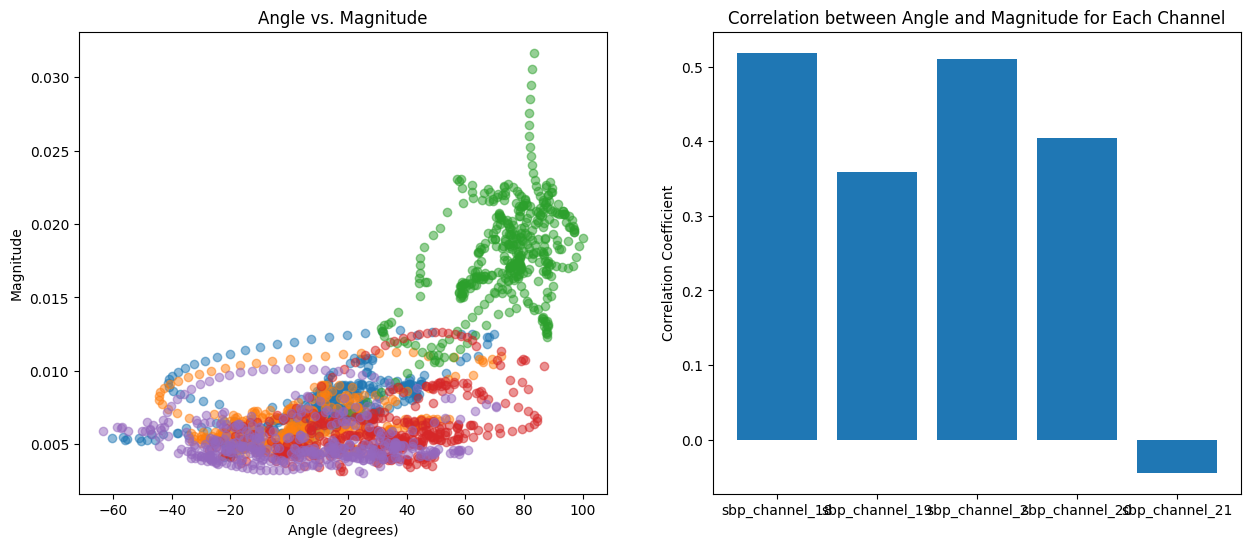

In [48]:

def plot_tuning_relationship(df_tuning, window_length=49, poly_order=3):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    correlations = []
    for channel in df_tuning['magnitude'].columns[10:15]:
        # Smooth data
        magnitude_smooth = savgol_filter(df_tuning['magnitude'][channel].values, window_length, poly_order)
        angle_smooth = savgol_filter(df_tuning['angle'][channel].values, window_length, poly_order)

        # Plot relationship in scatter plot
        axes[0].scatter(angle_smooth, magnitude_smooth, alpha=0.5, label=channel)
        
        # Calculate correlation
        corr = np.corrcoef(angle_smooth, magnitude_smooth)[0, 1]
        correlations.append((channel, corr))
    
    # Configure scatter plot
    axes[0].set_xlabel('Angle (degrees)')
    axes[0].set_ylabel('Magnitude')
    axes[0].set_title('Angle vs. Magnitude')
    # axes[0].legend()
    
    # Plot correlation over time
    channel_names, corr_values = zip(*correlations)
    axes[1].bar(channel_names, corr_values)
    axes[1].set_ylabel('Correlation Coefficient')
    axes[1].set_title('Correlation between Angle and Magnitude for Each Channel')
    plt.show()

plot_tuning_relationship(df_tuning)


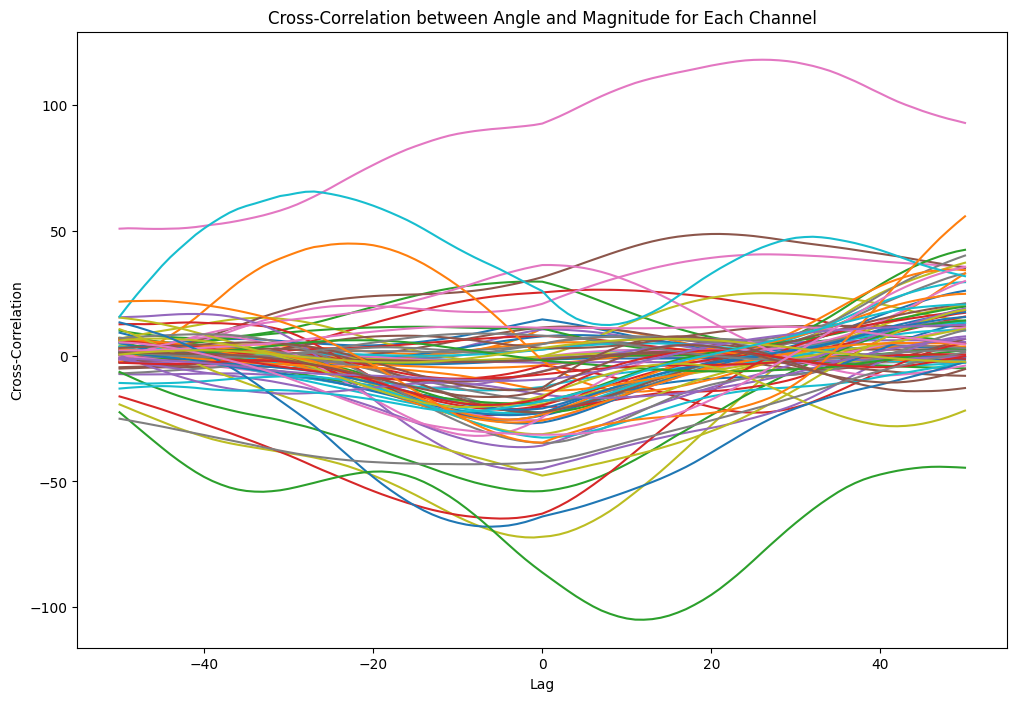

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, correlate

def plot_cross_correlation(df_tuning, max_lag=50, window_length=49, poly_order=3):
    fig, ax = plt.subplots(figsize=(12, 8))

    for channel in df_tuning['magnitude'].columns[:80]:  # Analyze first 5 channels
        # Smooth data
        magnitude_smooth = savgol_filter(df_tuning['magnitude'][channel].values, window_length, poly_order)
        angle_smooth = savgol_filter(df_tuning['angle'][channel].values, window_length, poly_order)
        
        # Calculate cross-correlation
        cross_corr = correlate(magnitude_smooth - np.mean(magnitude_smooth),
                               angle_smooth - np.mean(angle_smooth),
                               mode='full')
        
        # Generate lags
        lags = np.arange(-len(magnitude_smooth) + 1, len(magnitude_smooth))
        
        # Limit to max_lag for plotting
        lag_range = (lags >= -max_lag) & (lags <= max_lag)
        
        ax.plot(lags[lag_range], cross_corr[lag_range], label=channel)
    
    # Configure plot
    ax.set_xlabel('Lag')
    ax.set_ylabel('Cross-Correlation')
    ax.set_title('Cross-Correlation between Angle and Magnitude for Each Channel')
    #ax.legend()
    plt.show()

plot_cross_correlation(df_tuning)


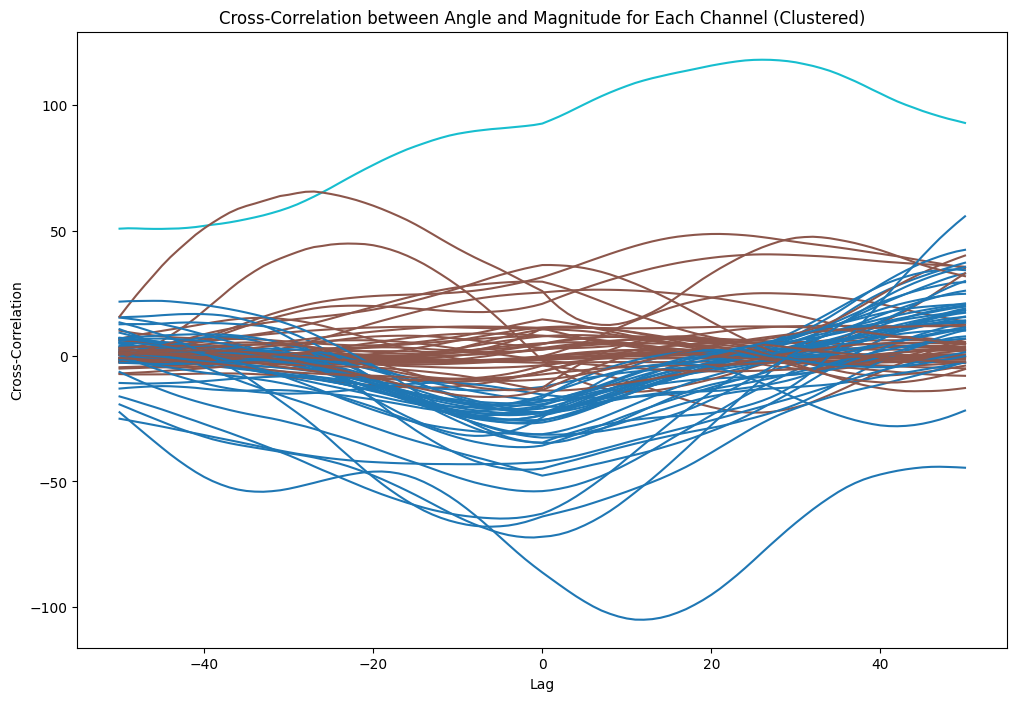

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, correlate
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def plot_cross_correlation_with_clusters(df_tuning, max_lag=50, window_length=49, poly_order=3, num_clusters=3):
    cross_correlation_vectors = []
    channel_names = df_tuning['magnitude'].columns[:80]  # Analyze the first 80 channels

    # Compute cross-correlation vectors for each channel
    for channel in channel_names:
        # Smooth data
        magnitude_smooth = savgol_filter(df_tuning['magnitude'][channel].values, window_length, poly_order)
        angle_smooth = savgol_filter(df_tuning['angle'][channel].values, window_length, poly_order)
        
        # Calculate cross-correlation
        cross_corr = correlate(magnitude_smooth - np.mean(magnitude_smooth),
                               angle_smooth - np.mean(angle_smooth),
                               mode='full')
        
        # Generate lags and limit to max_lag
        lags = np.arange(-len(magnitude_smooth) + 1, len(magnitude_smooth))
        lag_range = (lags >= -max_lag) & (lags <= max_lag)
        cross_corr_limited = cross_corr[lag_range]
        
        # Store the cross-correlation vector for PCA
        cross_correlation_vectors.append(cross_corr_limited)

    # Convert list to array for PCA (shape: num_channels x num_lags)
    cross_correlation_matrix = np.array(cross_correlation_vectors)
    
    # Perform PCA to reduce dimensionality
    pca = PCA(n_components=2)
    cross_corr_pca = pca.fit_transform(cross_correlation_matrix)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(cross_corr_pca)

    # Plot cross-correlation with cluster colors
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))  # Use a colormap for different clusters

    for idx, channel in enumerate(channel_names):
        ax.plot(lags[lag_range], cross_correlation_matrix[idx], color=colors[clusters[idx]], label=f'Channel {channel}' if idx < num_clusters else "")
    
    # Configure plot
    ax.set_xlabel('Lag')
    ax.set_ylabel('Cross-Correlation')
    ax.set_title('Cross-Correlation between Angle and Magnitude for Each Channel (Clustered)')
    plt.show()

# Example usage:
plot_cross_correlation_with_clusters(df_tuning)


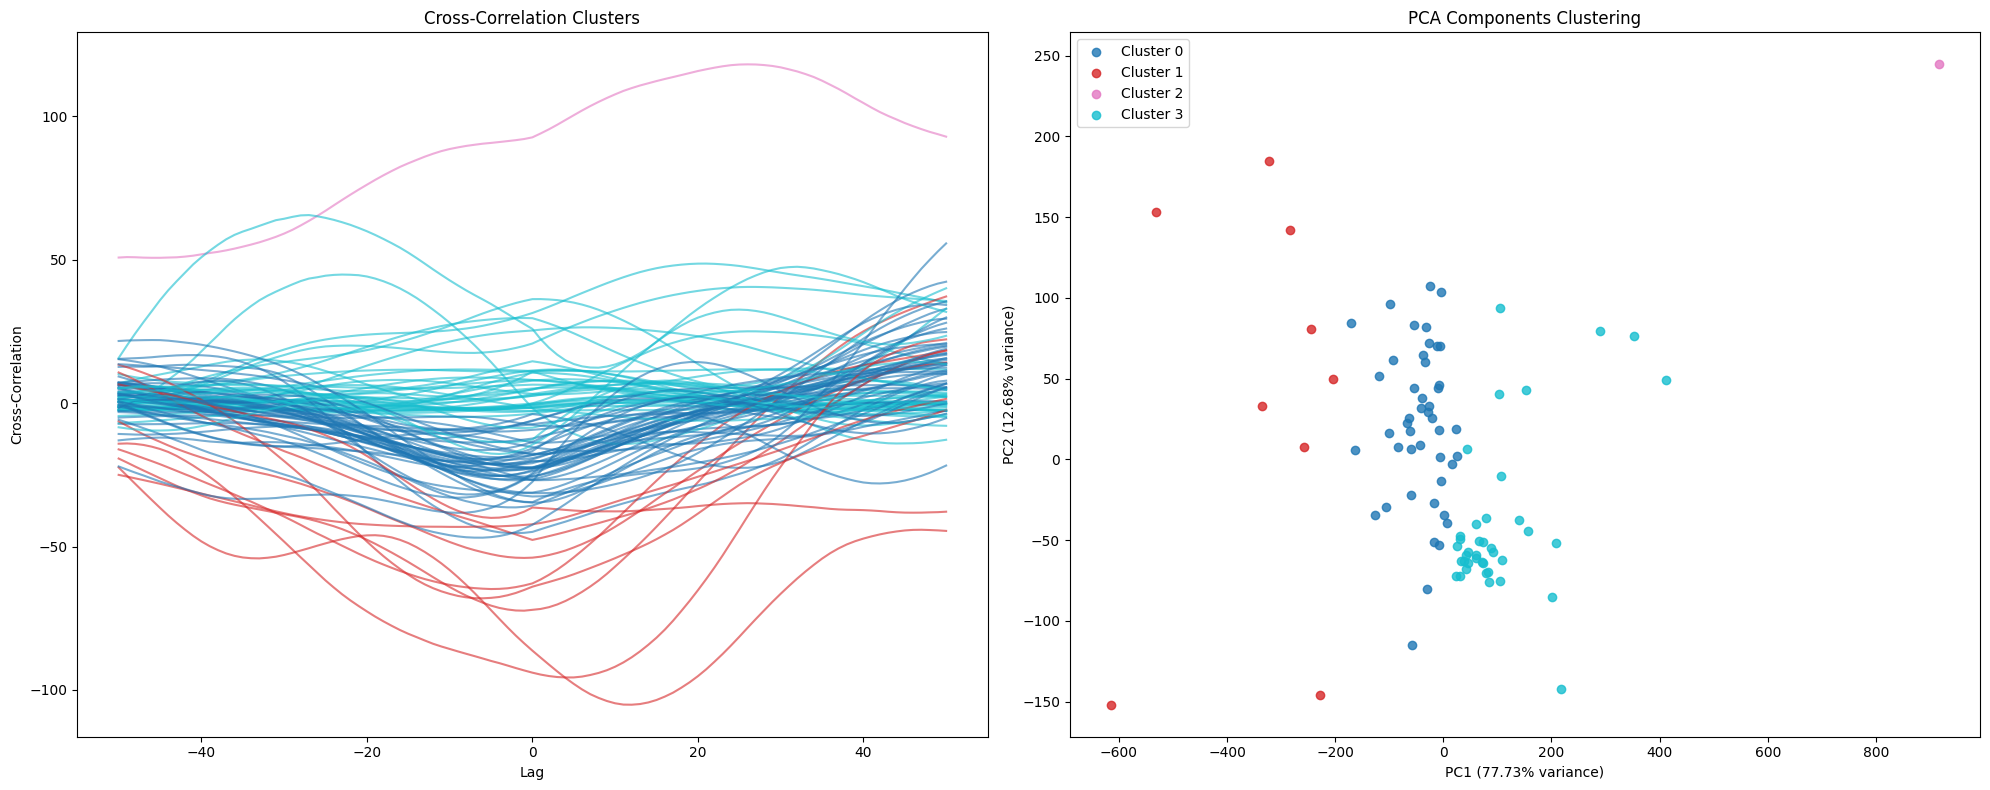

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, correlate
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def plot_cross_correlation_and_pca_clusters(df_tuning, max_lag=50, window_length=49, 
                                          poly_order=3, num_clusters=4):
    cross_correlation_vectors = []
    channel_names = df_tuning['magnitude'].columns[:94]

    # Compute cross-correlation vectors
    for channel in channel_names:
        magnitude_smooth = savgol_filter(df_tuning['magnitude'][channel].values, 
                                       window_length, poly_order)
        angle_smooth = savgol_filter(df_tuning['angle'][channel].values, 
                                   window_length, poly_order)
        
        cross_corr = correlate(magnitude_smooth - np.mean(magnitude_smooth),
                             angle_smooth - np.mean(angle_smooth),
                             mode='full')
        
        lags = np.arange(-len(magnitude_smooth) + 1, len(magnitude_smooth))
        lag_range = (lags >= -max_lag) & (lags <= max_lag)
        cross_corr_limited = cross_corr[lag_range]
        
        cross_correlation_vectors.append(cross_corr_limited)

    cross_correlation_matrix = np.array(cross_correlation_vectors)
    
    # PCA and clustering
    pca = PCA(n_components=2)
    cross_corr_pca = pca.fit_transform(cross_correlation_matrix)
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(cross_corr_pca)

    # Create subplot figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

    # Plot 1: Cross-correlations with cluster colors
    for idx, channel in enumerate(channel_names):
        ax1.plot(lags[lag_range], cross_correlation_matrix[idx], 
                color=colors[clusters[idx]], alpha=0.6)
    
    ax1.set_xlabel('Lag')
    ax1.set_ylabel('Cross-Correlation')
    ax1.set_title('Cross-Correlation Clusters')

    # Plot 2: PCA scatter plot
    for cluster_idx in range(num_clusters):
        mask = clusters == cluster_idx
        ax2.scatter(cross_corr_pca[mask, 0], cross_corr_pca[mask, 1], 
                   color=colors[cluster_idx], label=f'Cluster {cluster_idx}',
                   alpha=0.8)

    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.set_title('PCA Components Clustering')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return pca, clusters

# Example usage:
pca, clusters = plot_cross_correlation_and_pca_clusters(df_tuning)


In [37]:

from statsmodels.tsa.stattools import adfuller

def test_stationarity(df_tuning):
    results = {}
    for channel in df_tuning['magnitude'].columns:
        angle_result = adfuller(df_tuning['magnitude'][channel].values)
        results[channel] = {'angle_pvalue': angle_result[1]}
    return results

results = test_stationarity(df_tuning_mean_included)

print(results)
print("NOTE: Val < 0.05 means we can reject null hypothesis of random walk")

{'sbp_channel_0': {'angle_pvalue': np.float64(6.344831082833388e-11)}, 'sbp_channel_1': {'angle_pvalue': np.float64(9.22114759944605e-17)}, 'sbp_channel_10': {'angle_pvalue': np.float64(0.0025704175265073596)}, 'sbp_channel_11': {'angle_pvalue': np.float64(0.12310627647339872)}, 'sbp_channel_12': {'angle_pvalue': np.float64(9.539179965610028e-05)}, 'sbp_channel_13': {'angle_pvalue': np.float64(0.0005244226147273832)}, 'sbp_channel_14': {'angle_pvalue': np.float64(0.08586045682786558)}, 'sbp_channel_15': {'angle_pvalue': np.float64(0.00018259301371645274)}, 'sbp_channel_16': {'angle_pvalue': np.float64(5.150219355993803e-06)}, 'sbp_channel_17': {'angle_pvalue': np.float64(0.00022800853191444243)}, 'sbp_channel_18': {'angle_pvalue': np.float64(1.2056466236555337e-05)}, 'sbp_channel_19': {'angle_pvalue': np.float64(5.644207579091286e-16)}, 'sbp_channel_2': {'angle_pvalue': np.float64(0.00022753765434445117)}, 'sbp_channel_20': {'angle_pvalue': np.float64(1.0857615143382778e-05)}, 'sbp_cha

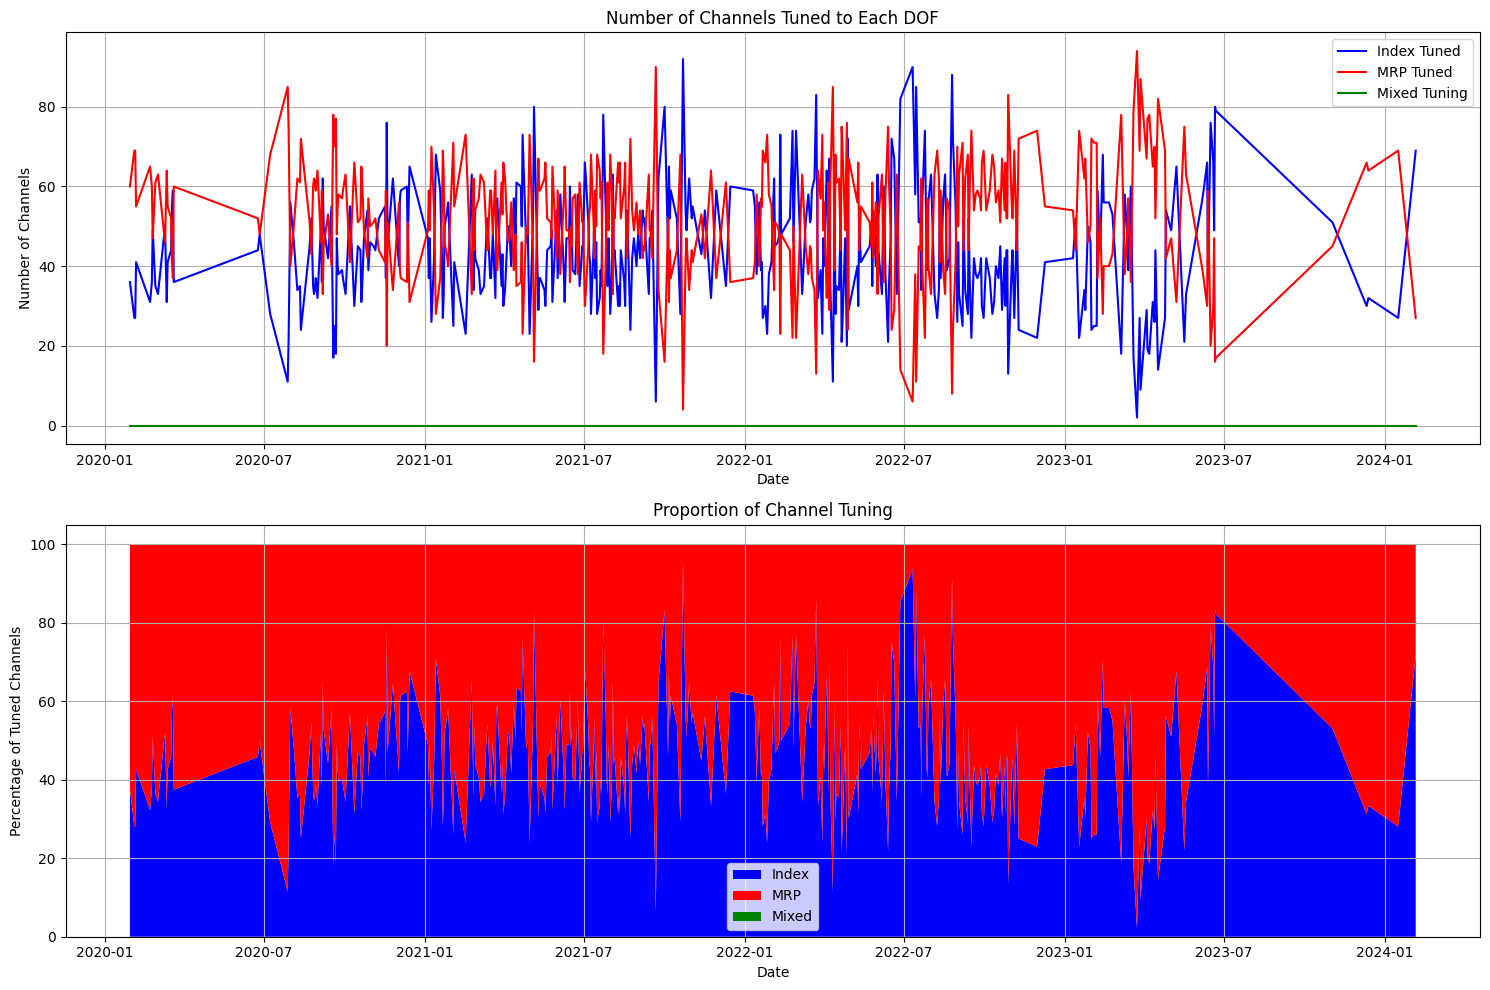


Average number of channels tuned to:
Index: 44.0
MRP: 51.9
Mixed: 0.0


In [15]:
def analyze_dof_tuning(df_tuning, angle_threshold=45):
    """
    Analyze how many channels are tuned to each DOF across time
    
    Parameters:
    - df_tuning: DataFrame with tuning data
    - angle_threshold: angle threshold to determine DOF tuning (default 45 degrees)
    """
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Initialize counters for each timepoint
    timepoints = df_tuning.index
    index_tuned = []
    mrp_tuned = []
    mixed_tuned = []
    
    for time in timepoints:
        # Get angles and magnitudes for this timepoint
        angles = df_tuning['angle'].loc[time]
        magnitudes = df_tuning['magnitude'].loc[time]
        
        # Count channels based on their tuning
        index_count = sum((abs(angles) <= angle_threshold) & (magnitudes > 0))
        mrp_count = sum((abs(angles) >= (90 - angle_threshold)) & (magnitudes > 0))
        mixed_count = sum((angle_threshold < abs(angles)) & 
                         (abs(angles) < (90 - angle_threshold)) & 
                         (magnitudes > 0))
        
        index_tuned.append(index_count)
        mrp_tuned.append(mrp_count)
        mixed_tuned.append(mixed_count)
    
    # Plot number of channels tuned to each DOF over time
    ax1.plot(timepoints, index_tuned, 'b-', label='Index Tuned')
    ax1.plot(timepoints, mrp_tuned, 'r-', label='MRP Tuned')
    ax1.plot(timepoints, mixed_tuned, 'g-', label='Mixed Tuning')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Channels')
    ax1.set_title('Number of Channels Tuned to Each DOF')
    ax1.legend()
    ax1.grid(True)
    
    # Plot proportion of channels
    total_channels = np.array(index_tuned) + np.array(mrp_tuned) + np.array(mixed_tuned)
    ax2.stackplot(timepoints, 
                 [index_tuned/total_channels*100,
                  mrp_tuned/total_channels*100,
                  mixed_tuned/total_channels*100],
                 labels=['Index', 'MRP', 'Mixed'],
                 colors=['blue', 'red', 'green'])
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Percentage of Tuned Channels')
    ax2.set_title('Proportion of Channel Tuning')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nAverage number of channels tuned to:")
    print(f"Index: {np.mean(index_tuned):.1f}")
    print(f"MRP: {np.mean(mrp_tuned):.1f}")
    print(f"Mixed: {np.mean(mixed_tuned):.1f}")

analyze_dof_tuning(df_tuning, angle_threshold=45)


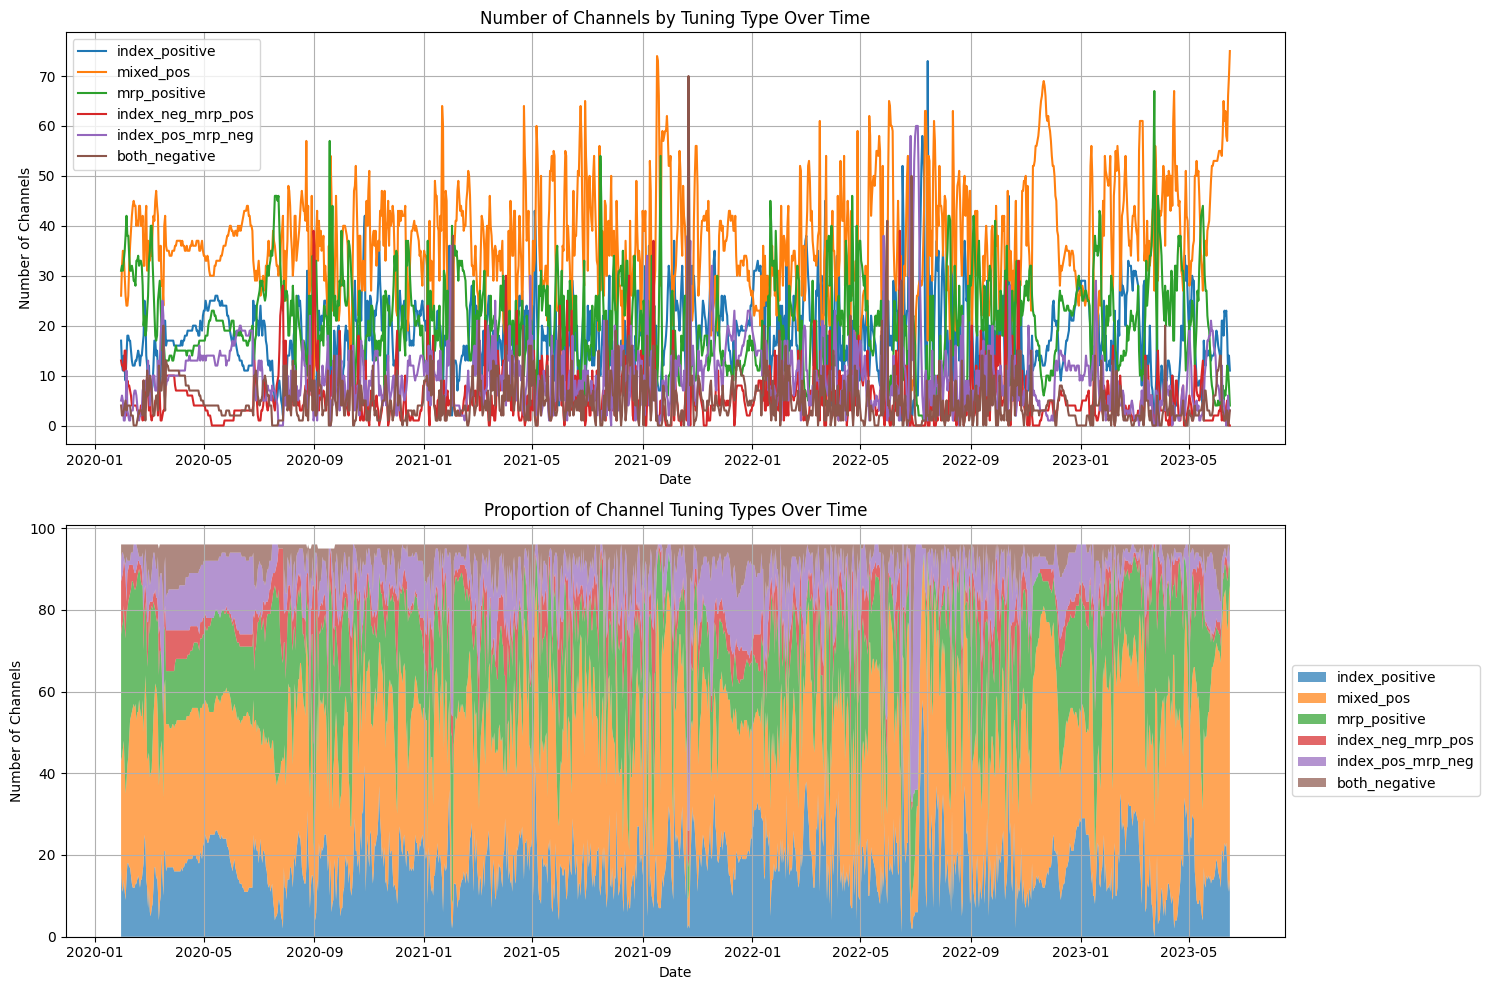


Average number of channels in each category:
index_positive: 17.8
mixed_pos: 37.0
mrp_positive: 20.8
index_neg_mrp_pos: 5.6
index_pos_mrp_neg: 9.8
both_negative: 5.1


{'index_positive': [17,
  12,
  11,
  14,
  11,
  9,
  14,
  18,
  18,
  17,
  17,
  15,
  13,
  12,
  12,
  12,
  13,
  13,
  14,
  15,
  14,
  12,
  14,
  14,
  16,
  18,
  25,
  23,
  14,
  12,
  7,
  12,
  6,
  5,
  7,
  8,
  12,
  17,
  17,
  14,
  15,
  11,
  4,
  8,
  10,
  20,
  15,
  10,
  21,
  21,
  16,
  17,
  17,
  17,
  17,
  17,
  17,
  17,
  17,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  17,
  16,
  17,
  17,
  18,
  18,
  18,
  19,
  19,
  19,
  19,
  19,
  19,
  20,
  20,
  20,
  20,
  19,
  19,
  18,
  18,
  21,
  20,
  19,
  22,
  23,
  23,
  25,
  24,
  23,
  23,
  24,
  25,
  25,
  25,
  25,
  25,
  25,
  26,
  26,
  26,
  25,
  25,
  24,
  24,
  25,
  24,
  24,
  24,
  24,
  24,
  22,
  22,
  21,
  19,
  18,
  17,
  16,
  18,
  19,
  17,
  16,
  15,
  14,
  14,
  13,
  13,
  13,
  12,
  12,
  11,
  11,
  11,
  11,
  11,
  12,
  12,
  12,
  12,
  12,
  25,
  21,
  24,
  22,
  21,
  21,
  18,
  21,
  24,
  20,
  18,
  21,
  21,
  20,
  17,
  16,
  13,
  12,


In [20]:
def analyze_tuning_characteristics(df_tuning):
    # Initialize counters for different tuning types
    tuning_counts = {
        'index_positive': [],    # 0° ± 22.5°
        'mixed_pos': [],         # 22.5° to 67.5°
        'mrp_positive': [],      # 67.5° to 112.5°
        'index_neg_mrp_pos': [], # 112.5° to 180°
        'index_pos_mrp_neg': [], # -90° to -22.5°
        'both_negative': [],     # -180° to -90°
    }
    
    df_tuning = df_tuning.resample('D').interpolate(method='linear')
    # Process data for each timepoint
    for time in df_tuning.index:
        counts = {k: 0 for k in tuning_counts.keys()}
        
        for channel in df_tuning['angle'].columns:
            angle = df_tuning['angle'].loc[time, channel]
            magnitude = df_tuning['magnitude'].loc[time, channel]
            
            if magnitude > 0:  # Only consider significant tuning
                if -22.5 <= angle <= 22.5:
                    counts['index_positive'] += 1
                elif 22.5 < angle < 67.5:
                    counts['mixed_pos'] += 1
                elif 67.5 <= angle <= 112.5:
                    counts['mrp_positive'] += 1
                elif 112.5 < angle <= 180:
                    counts['index_neg_mrp_pos'] += 1
                elif -90 <= angle < -22.5:
                    counts['index_pos_mrp_neg'] += 1
                elif -180 <= angle < -90:
                    counts['both_negative'] += 1
        
        # Store counts for this timepoint
        for k in tuning_counts:
            tuning_counts[k].append(counts[k])
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Time series plot
    for category, values in tuning_counts.items():
        ax1.plot(df_tuning.index, values, label=category)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Channels')
    ax1.set_title('Number of Channels by Tuning Type Over Time')
    ax1.legend()
    ax1.grid(True)
    
    # Stacked area plot
    data = np.array(list(tuning_counts.values()))
    ax2.stackplot(df_tuning.index, data, 
                 labels=tuning_counts.keys(),
                 alpha=0.7)
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Number of Channels')
    ax2.set_title('Proportion of Channel Tuning Types Over Time')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nAverage number of channels in each category:")
    for category in tuning_counts:
        mean_count = np.mean(tuning_counts[category])
        print(f"{category}: {mean_count:.1f}")
    
    return tuning_counts

analyze_tuning_characteristics(df_tuning_mean_included)

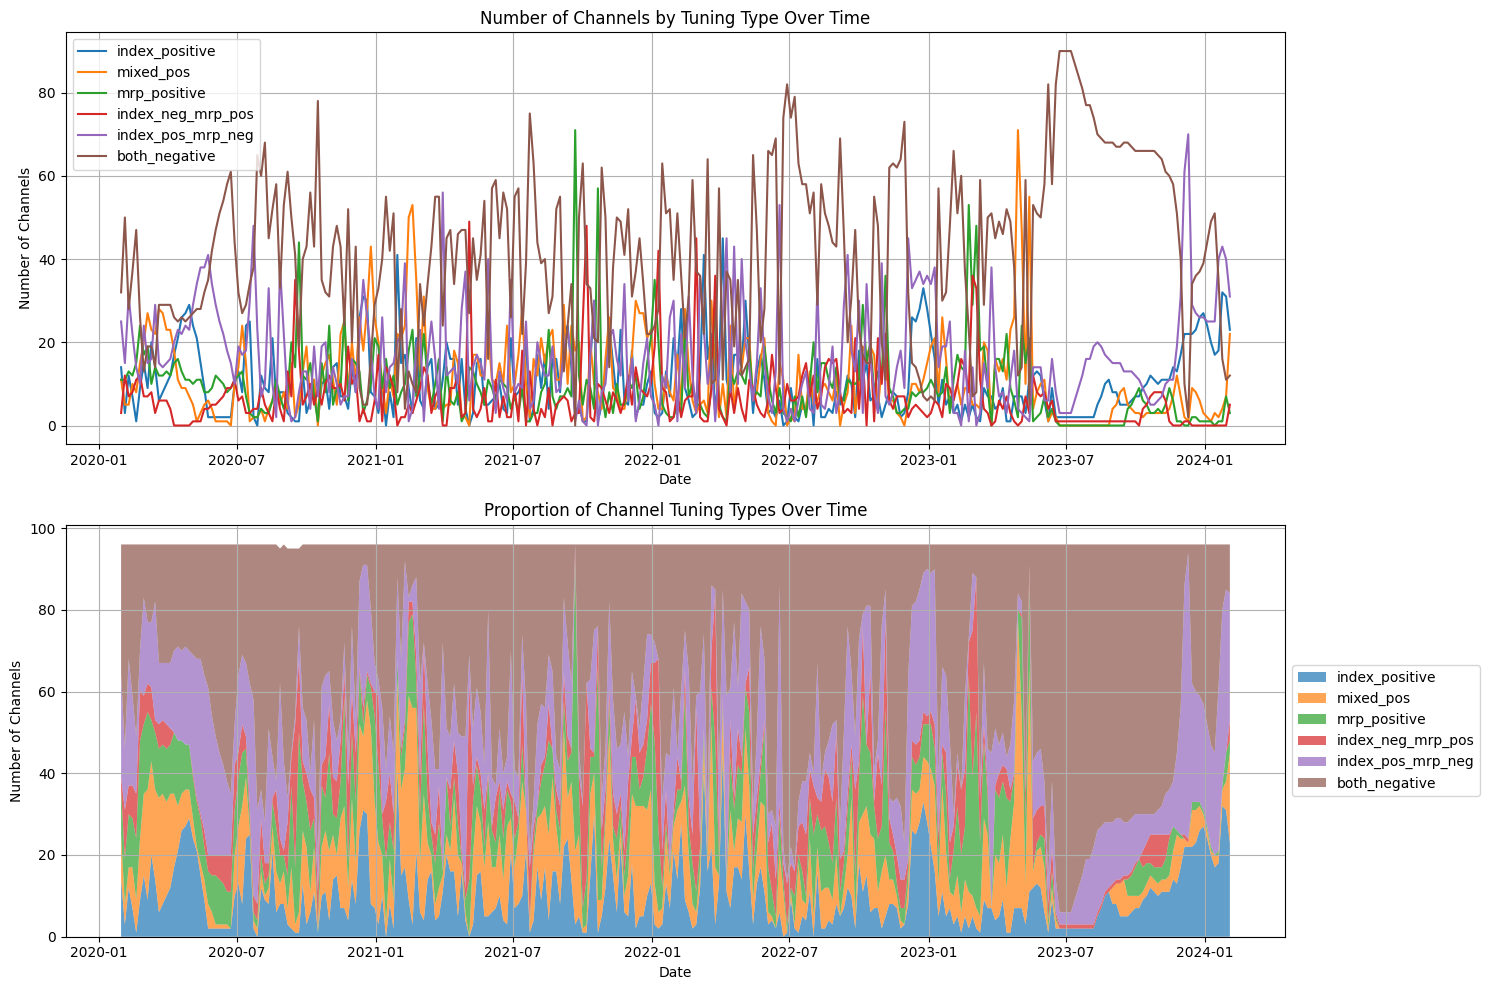


Average number of channels in each category:
index_positive: 10.4
mixed_pos: 11.1
mrp_positive: 9.4
index_neg_mrp_pos: 6.6
index_pos_mrp_neg: 16.5
both_negative: 41.9

Average Magnitudes:
Negative angles (-180° to -90°): 0.02
All other angles: 0.01


{'index_positive': [np.int64(14),
  np.int64(3),
  np.int64(12),
  np.int64(7),
  np.int64(1),
  np.int64(9),
  np.int64(15),
  np.int64(9),
  np.int64(20),
  np.int64(14),
  np.int64(6),
  np.int64(8),
  np.int64(10),
  np.int64(12),
  np.int64(17),
  np.int64(21),
  np.int64(26),
  np.int64(27),
  np.int64(29),
  np.int64(24),
  np.int64(21),
  np.int64(15),
  np.int64(9),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(10),
  np.int64(13),
  np.int64(8),
  np.int64(24),
  np.int64(25),
  np.int64(2),
  np.int64(0),
  np.int64(12),
  np.int64(9),
  np.int64(8),
  np.int64(21),
  np.int64(6),
  np.int64(8),
  np.int64(8),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(1),
  np.int64(13),
  np.int64(3),
  np.int64(6),
  np.int64(11),
  np.int64(1),
  np.int64(10),
  np.int64(11),
  np.int64(4),
  np.int64(14),
  np.int64(15),
  np.int64(7),
  np.int64(7),
  np.int64(4),
  np.int64(14),
  np.int64(8),
  np.int6

In [75]:
def analyze_tuning_characteristics(df_tuning):
    # Define angle boundaries for categories
    angle_categories = {
        'index_positive': (-22.5, 22.5),
        'mixed_pos': (22.5, 67.5),
        'mrp_positive': (67.5, 112.5),
        'index_neg_mrp_pos': (112.5, 180),
        'index_pos_mrp_neg': (-90, -22.5),
        'both_negative': (-180, -90)
    }

    df_tuning = df_tuning.resample('D').interpolate(method='linear')
    
    # Use vectorized operations instead of loops
    def categorize_angles(angles, magnitudes):
        counts = {k: 0 for k in angle_categories}
        mask = magnitudes > 0
        valid_angles = angles[mask]
        
        for category, (lower, upper) in angle_categories.items():
            counts[category] = np.sum((valid_angles >= lower) & (valid_angles <= upper))
        
        return counts
    
    # Process all channels at once for each timepoint
    tuning_counts = {category: [] for category in angle_categories}
    
    # Vectorized operation over timepoints
    for time in df_tuning.index[::5]:  # Sample every 5th timepoint
        angles = df_tuning['angle'].loc[time]
        magnitudes = df_tuning['magnitude'].loc[time]
        counts = categorize_angles(angles, magnitudes)
        
        for category in angle_categories:
            tuning_counts[category].append(counts[category])
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    timepoints = df_tuning.index[::5]  # Use same sampling as above
    
    # Time series plot
    for category, values in tuning_counts.items():
        ax1.plot(timepoints, values, label=category)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Channels')
    ax1.set_title('Number of Channels by Tuning Type Over Time')
    ax1.legend()
    ax1.grid(True)
    
    # Stacked area plot
    data = np.array(list(tuning_counts.values()))
    ax2.stackplot(timepoints, data, 
                 labels=tuning_counts.keys(),
                 alpha=0.7)
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Number of Channels')
    ax2.set_title('Proportion of Channel Tuning Types Over Time')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nAverage number of channels in each category:")
    for category in tuning_counts:
        mean_count = np.mean(tuning_counts[category])
        print(f"{category}: {mean_count:.1f}")


    mask_negative = (df_tuning['angle'] >= -180) & (df_tuning['angle'] < -90)
    mask_positive = (df_tuning['angle'] >= 0) & (df_tuning['angle'] < 90)
    avg_magnitude_negative = df_tuning['magnitude'][mask_negative].mean().mean()
    
    mask_elsewhere = ~mask_negative
    avg_magnitude_elsewhere = df_tuning['magnitude'][mask_positive].mean().mean()
    
    print("\nAverage Magnitudes:")
    print(f"Negative angles (-180° to -90°): {avg_magnitude_negative:.2f}")
    print(f"All other angles: {avg_magnitude_elsewhere:.2f}")
    
    return tuning_counts

analyze_tuning_characteristics(df_tuning)


In [17]:
def analyze_channel_preferences(df_tuning):
    # Initialize counters for different tuning types
    tuning_counts = {
        'index_positive': {},    # 0° ± 22.5°
        'mixed_pos': {},         # 22.5° to 67.5°
        'mrp_positive': {},      # 67.5° to 112.5°
        'index_neg_mrp_pos': {}, # 112.5° to 180°
        'index_pos_mrp_neg': {}, # -90° to -22.5°
        'both_negative': {},     # -180° to -90°
    }
    
    # Count occurrences for each channel in each category
    for time in df_tuning.index:
        for channel in df_tuning['angle'].columns:
            angle = df_tuning['angle'].loc[time, channel]
            magnitude = df_tuning['magnitude'].loc[time, channel]
            
            # Initialize counter for this channel if not exists
            for category in tuning_counts:
                if channel not in tuning_counts[category]:
                    tuning_counts[category][channel] = 0
            
            if magnitude > 0:  # Only consider significant tuning
                if -22.5 <= angle <= 22.5:
                    tuning_counts['index_positive'][channel] += 1
                elif 22.5 < angle < 67.5:
                    tuning_counts['mixed_pos'][channel] += 1
                elif 67.5 <= angle <= 112.5:
                    tuning_counts['mrp_positive'][channel] += 1
                elif 112.5 < angle <= 180:
                    tuning_counts['index_neg_mrp_pos'][channel] += 1
                elif -90 <= angle < -22.5:
                    tuning_counts['index_pos_mrp_neg'][channel] += 1
                elif -180 <= angle < -90:
                    tuning_counts['both_negative'][channel] += 1
    
    # Calculate total timepoints for percentage calculation
    total_timepoints = len(df_tuning.index)
    
    # Find dominant category for each channel
    channel_dominance = {}
    for channel in df_tuning['angle'].columns:
        channel_counts = {category: tuning_counts[category][channel] 
                        for category in tuning_counts}
        dominant_category = max(channel_counts.items(), key=lambda x: x[1])
        channel_dominance[channel] = {
            'dominant_category': dominant_category[0],
            'percentage': (dominant_category[1] / total_timepoints) * 100
        }
    
    # Print summary
    print("\nChannel Tuning Analysis:")
    print("-----------------------")
    
    # Print dominant categories for each channel
    print("\nDominant tuning category for each channel:")
    for channel, info in channel_dominance.items():
        print(f"{channel}: {info['dominant_category']} ({info['percentage']:.1f}% of time)")
    
    # Print most common channels for each category
    print("\nMost common channels in each category:")
    for category in tuning_counts:
        channel_percentages = {
            channel: (count / total_timepoints) * 100 
            for channel, count in tuning_counts[category].items()
        }
        # Sort channels by percentage
        sorted_channels = sorted(channel_percentages.items(), 
                               key=lambda x: x[1], 
                               reverse=True)
        
        print(f"\n{category}:")
        for channel, percentage in sorted_channels:
            if percentage > 0:  # Only show channels that appear in this category
                print(f"  {channel}: {percentage:.1f}% of time")
    
    return tuning_counts, channel_dominance

# Call the function
tuning_counts, channel_dominance = analyze_channel_preferences(df_tuning)



Channel Tuning Analysis:
-----------------------

Dominant tuning category for each channel:
sbp_channel_0: mrp_positive (57.5% of time)
sbp_channel_1: mixed_pos (55.3% of time)
sbp_channel_10: mixed_pos (56.0% of time)
sbp_channel_11: mixed_pos (51.4% of time)
sbp_channel_12: mixed_pos (62.6% of time)
sbp_channel_13: mixed_pos (56.3% of time)
sbp_channel_14: mixed_pos (43.7% of time)
sbp_channel_15: mixed_pos (61.1% of time)
sbp_channel_16: mixed_pos (52.9% of time)
sbp_channel_17: mixed_pos (55.6% of time)
sbp_channel_18: mixed_pos (60.9% of time)
sbp_channel_19: mixed_pos (51.4% of time)
sbp_channel_2: mrp_positive (64.3% of time)
sbp_channel_20: mixed_pos (50.7% of time)
sbp_channel_21: mixed_pos (57.2% of time)
sbp_channel_22: mixed_pos (51.7% of time)
sbp_channel_23: mixed_pos (58.7% of time)
sbp_channel_24: mixed_pos (57.7% of time)
sbp_channel_25: mixed_pos (57.2% of time)
sbp_channel_26: mixed_pos (58.0% of time)
sbp_channel_27: mixed_pos (58.7% of time)
sbp_channel_28: mixed

/var/folders/vs/x5my52wn5jv64c7gz3gxk3th0000gn/T/ipykernel_25480/3051832737.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integrated = np.trapz(combined_signal)
/var/folders/vs/x5my52wn5jv64c7gz3gxk3th0000gn/T/ipykernel_25480/3051832737.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'magnitude_only': np.trapz(mag_norm),
/var/folders/vs/x5my52wn5jv64c7gz3gxk3th0000gn/T/ipykernel_25480/3051832737.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  'angle_only': np.trapz(ang_norm)


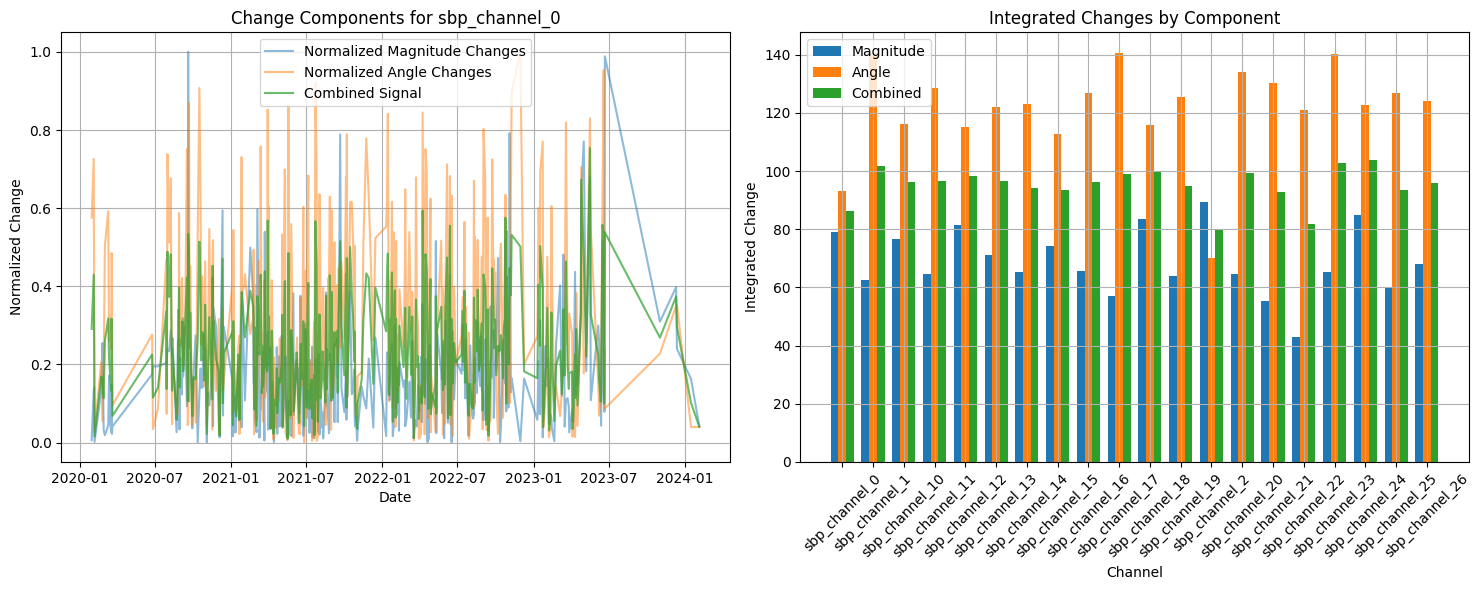

In [18]:
def analyze_integrated_tuning_with_angle(df_tuning):
    """
    Analyze integrated changes considering both magnitude and angle changes
    """
    integrated_changes = {}
    
    for channel in df_tuning['magnitude'].columns[:20]:
        # Get magnitude and angle data
        magnitude = df_tuning['magnitude'][channel].values
        angle = df_tuning['angle'][channel].values
        
        # Process magnitude
        mag_baseline_removed = magnitude - np.min(magnitude)
        mag_mean_subtracted = mag_baseline_removed - np.mean(mag_baseline_removed)
        
        # Process angle (need to handle circular nature of angles)
        # Convert to radians and handle wraparound
        angle_rad = np.deg2rad(angle)
        angle_diff = np.diff(np.unwrap(angle_rad))  # Gets continuous angle changes
        
        # Combine magnitude and angle changes
        # Weight them equally by normalizing each
        mag_changes = np.abs(mag_mean_subtracted)
        ang_changes = np.abs(angle_diff)  # One element shorter than magnitude
        
        # Normalize each component
        mag_norm = mag_changes / np.max(mag_changes)
        ang_norm = np.append(ang_changes, ang_changes[-1]) / np.max(ang_changes)  # Append last value to match length
        
        # Combined signal (can adjust weights if needed)
        combined_signal = (mag_norm + ang_norm) / 2
        
        # Integrate
        integrated = np.trapz(combined_signal)
        
        integrated_changes[channel] = {
            'total': integrated,
            'magnitude_only': np.trapz(mag_norm),
            'angle_only': np.trapz(ang_norm)
        }
    
    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Example plot for first channel
    channel = df_tuning['magnitude'].columns[0]
    dates = df_tuning.index
    
    # Plot components
    ax1.plot(dates, mag_norm, label='Normalized Magnitude Changes', alpha=0.5)
    ax1.plot(dates, ang_norm, label='Normalized Angle Changes', alpha=0.5)
    ax1.plot(dates, combined_signal, label='Combined Signal', alpha=0.7)
    ax1.set_title(f'Change Components for {channel}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Change')
    ax1.legend()
    ax1.grid(True)
    
    # Bar plot comparing different measures
    channels = list(integrated_changes.keys())
    total_values = [d['total'] for d in integrated_changes.values()]
    mag_values = [d['magnitude_only'] for d in integrated_changes.values()]
    ang_values = [d['angle_only'] for d in integrated_changes.values()]
    
    x = np.arange(len(channels))
    width = 0.25
    
    ax2.bar(x - width, mag_values, width, label='Magnitude')
    ax2.bar(x, ang_values, width, label='Angle')
    ax2.bar(x + width, total_values, width, label='Combined')
    
    ax2.set_title('Integrated Changes by Component')
    ax2.set_xlabel('Channel')
    ax2.set_ylabel('Integrated Change')
    ax2.set_xticks(x)
    ax2.set_xticklabels(channels, rotation=45)
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return integrated_changes

# Call the function
integrated_changes = analyze_integrated_tuning_with_angle(df_tuning)
